In [1]:
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt

from ud_sac import UDSAC, rollout, sample_episode, train, evaluate_agent
from core import MeanController, Episode

In [ ]:
# def plot_agent_perf(env, agent, test_episodes=10):
#     desired_returns = np.linspace(10, 195, 50)
    
#     actual_returns = [[rollout(env, agent, dr, dr)[0] for _ in range(test_episodes)] for dr in desired_returns]
#     actual_returns = np.stack(actual_returns)
    
#     actual_means, actual_stds = actual_returns.mean(axis=1), actual_returns.std(axis=1)
    
#     plt.figure(figsize=(12, 8))
#     plt.plot(desired_returns, actual_means);
#     plt.fill_between(desired_returns, actual_means - actual_stds, actual_means + actual_stds)
#     plt.xlabel("Desired return")
#     plt.ylabel("Actual return")
#     plt.title("CartPole-v0");

In [2]:
# agent = torch.load("trained_agents/CartPoleBest.pt", map_location='cpu')
agent = torch.load("udsac_test_147.pt", map_location='cpu')
env = gym.make("LunarLander-v2")

In [3]:
dr, dh, err = evaluate_agent("LunarLander-v2", agent, (-400, 200), (50, 280), num=15)
err.mean()

149.9381263465055

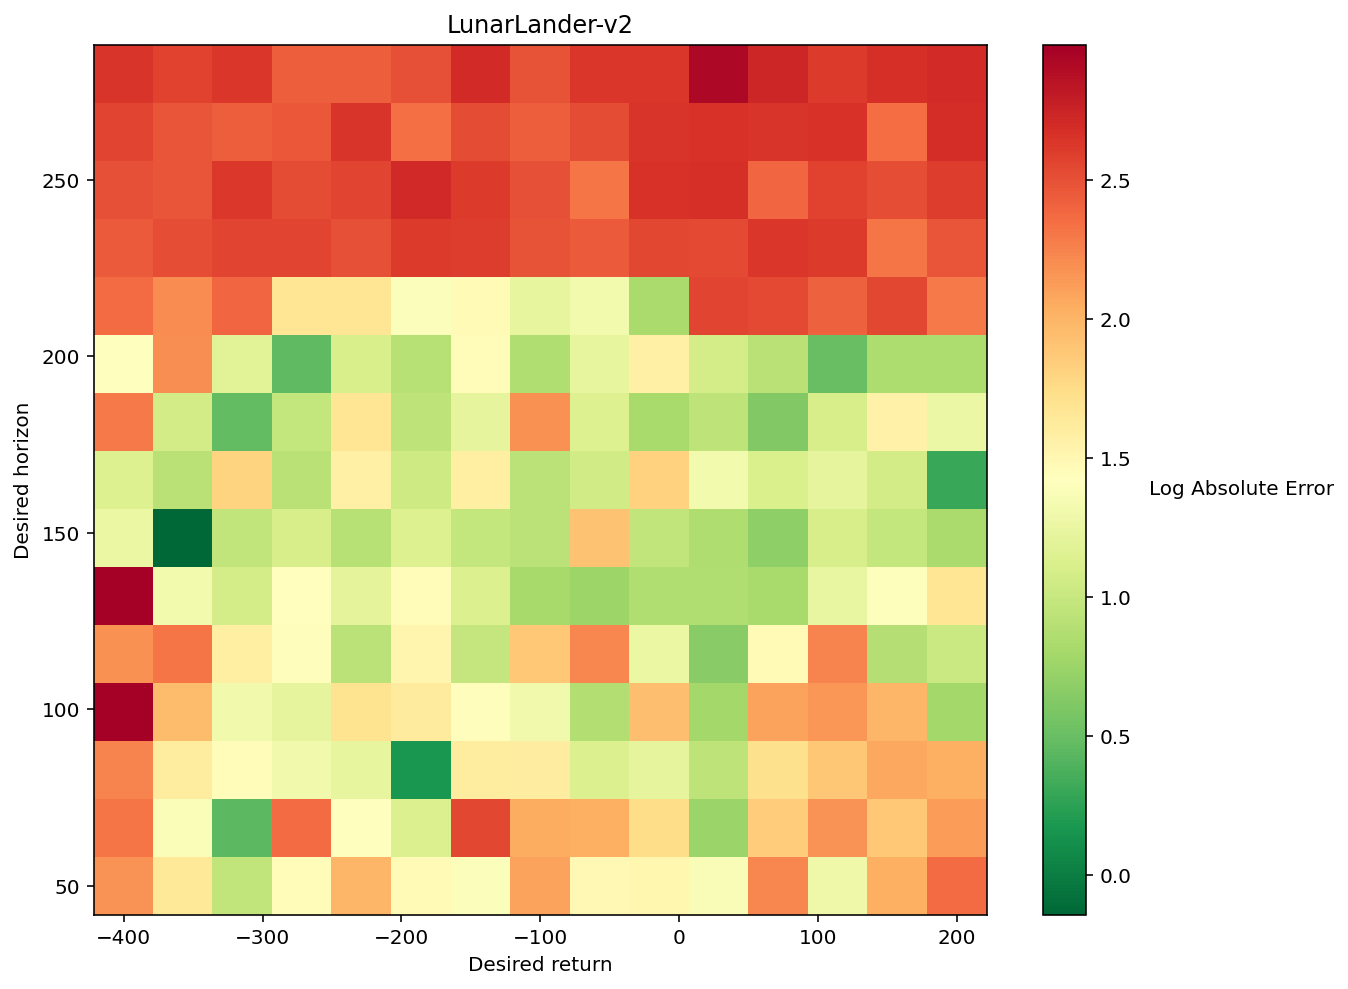

In [4]:
%config InlineBackend.figure_format = 'retina'

import matplotlib.colors as colors

err_log = np.log10(err)

plt.figure(figsize=(10, 8))
plt.pcolormesh(dr, dh, err_log, vmin=err_log.min(), vmax=err_log.max(), cmap='RdYlGn_r', shading="auto")
plt.xlabel("Desired return")
plt.ylabel("Desired horizon")
plt.title("LunarLander-v2")

cbar = plt.colorbar()
cbar.set_label("Log Absolute Error", rotation=0, labelpad=55);

# Rewards

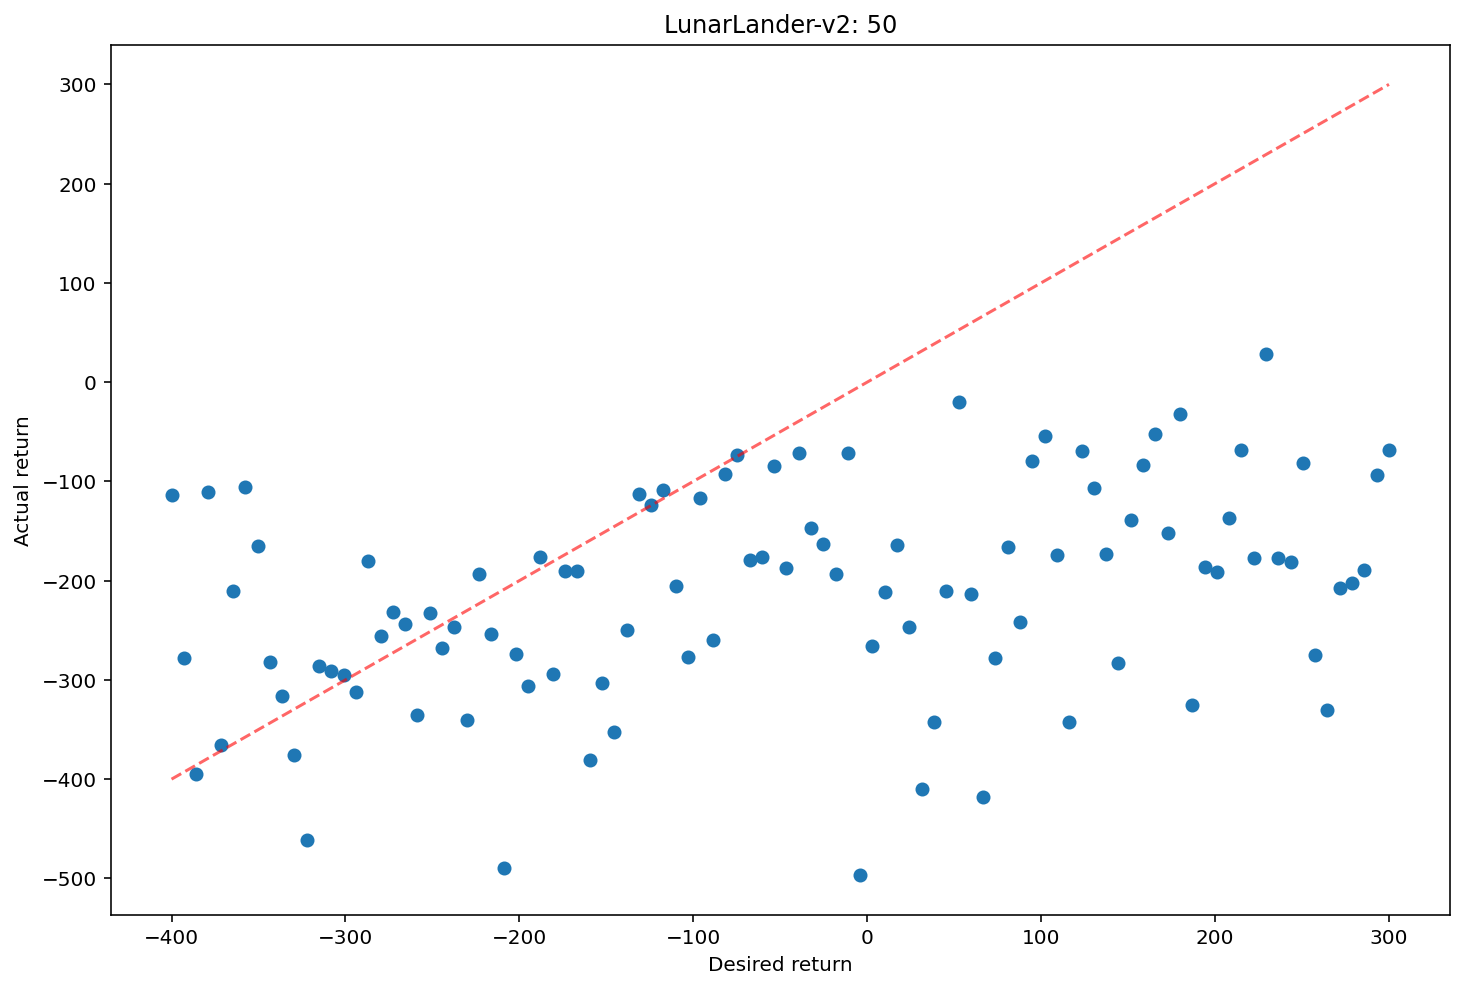

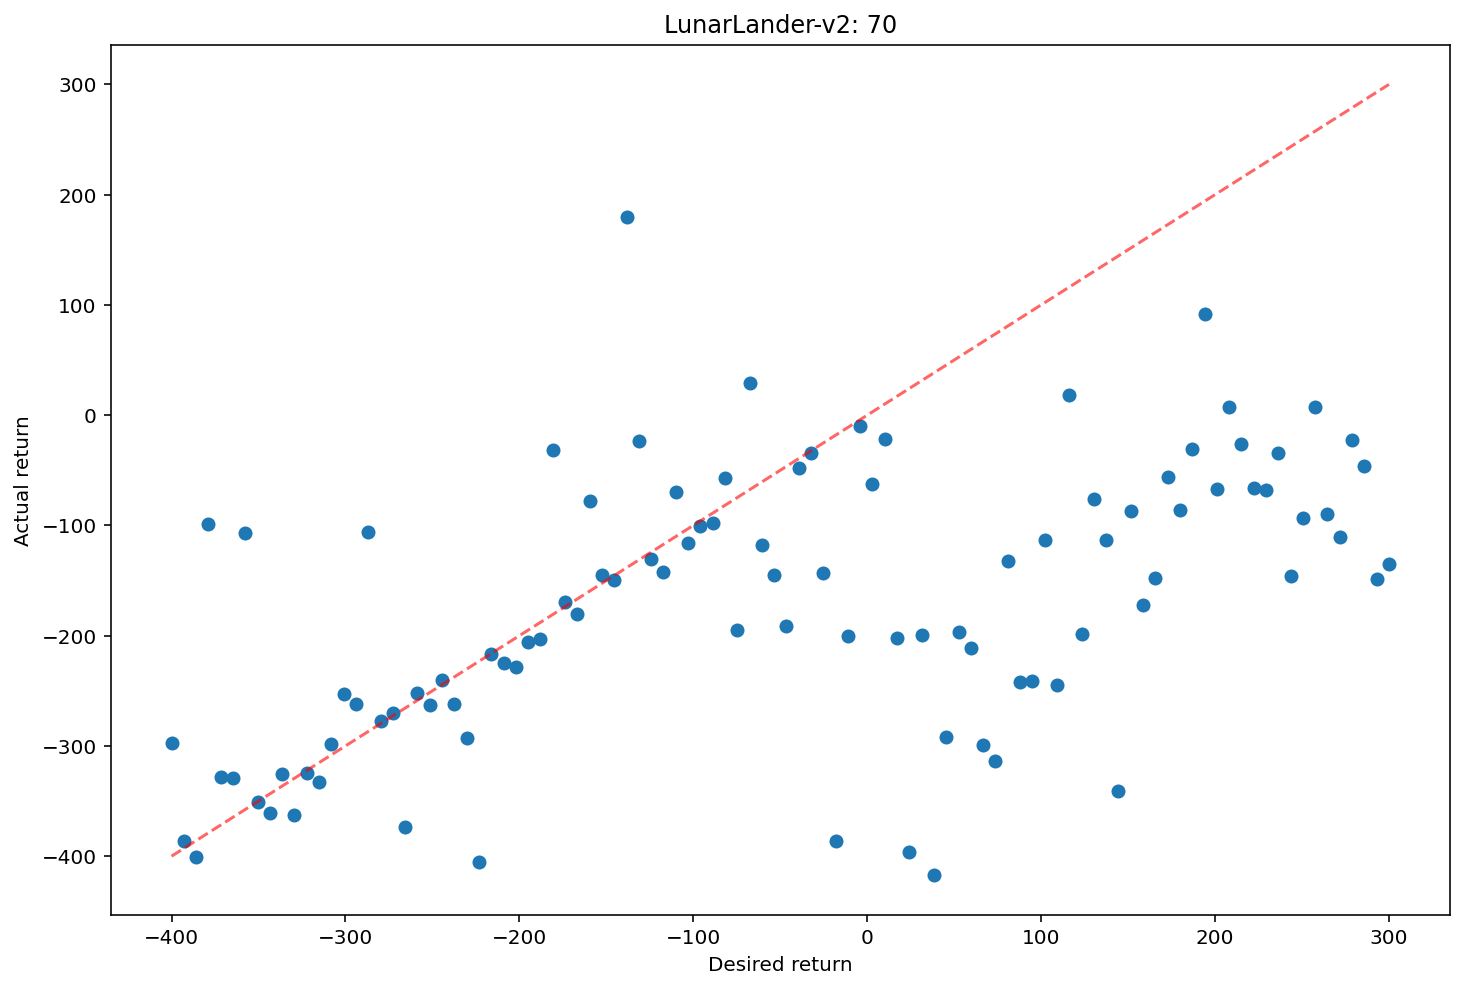

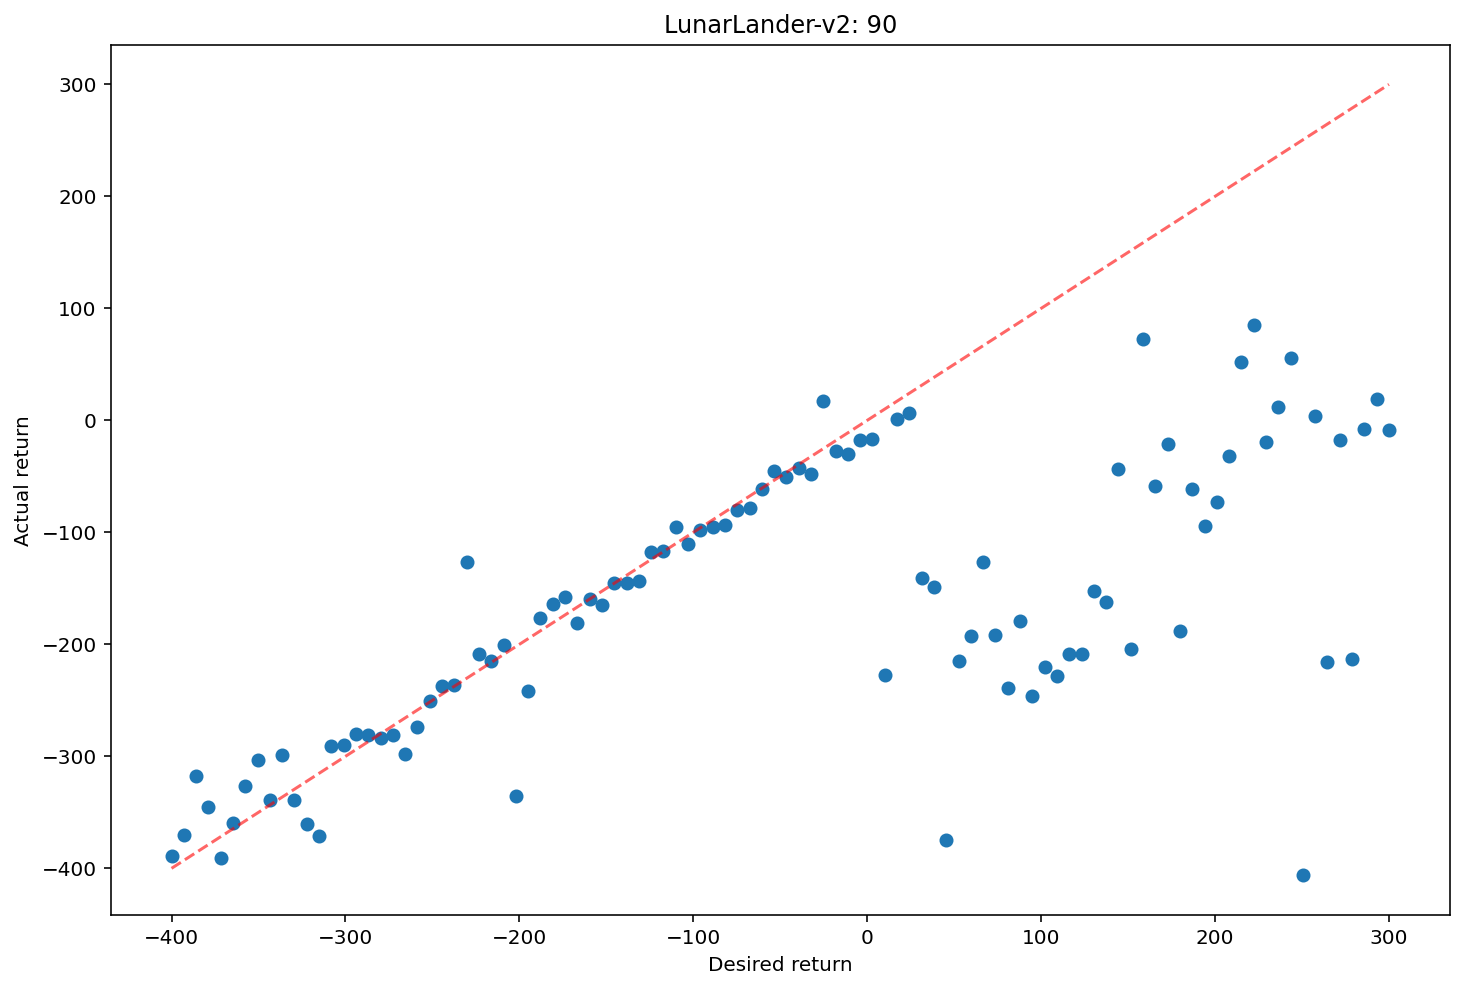

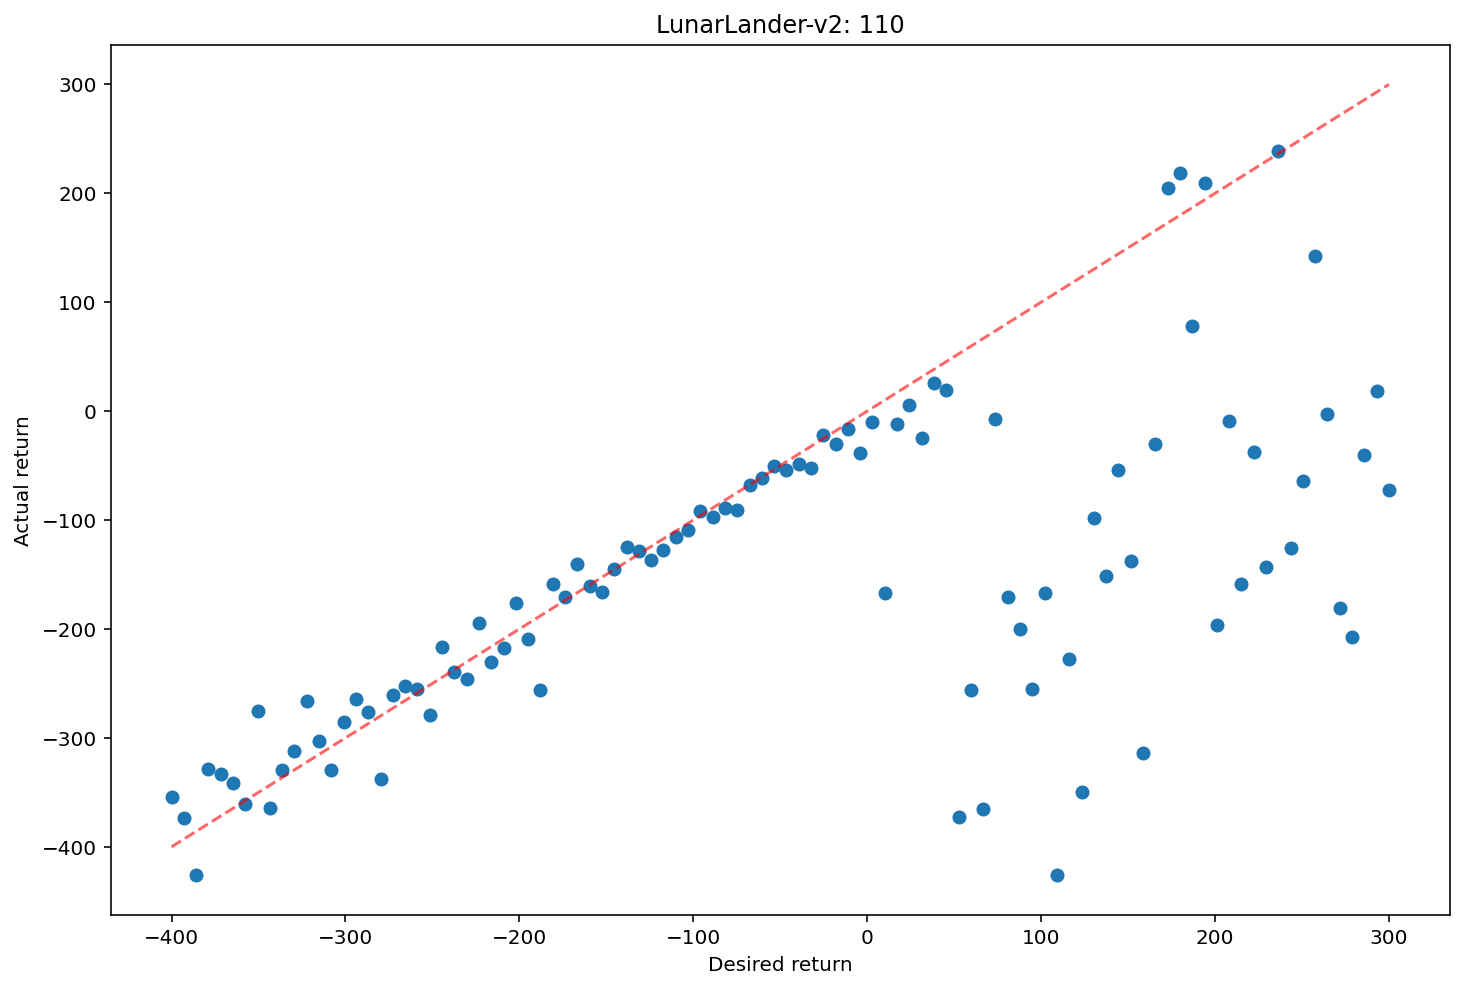

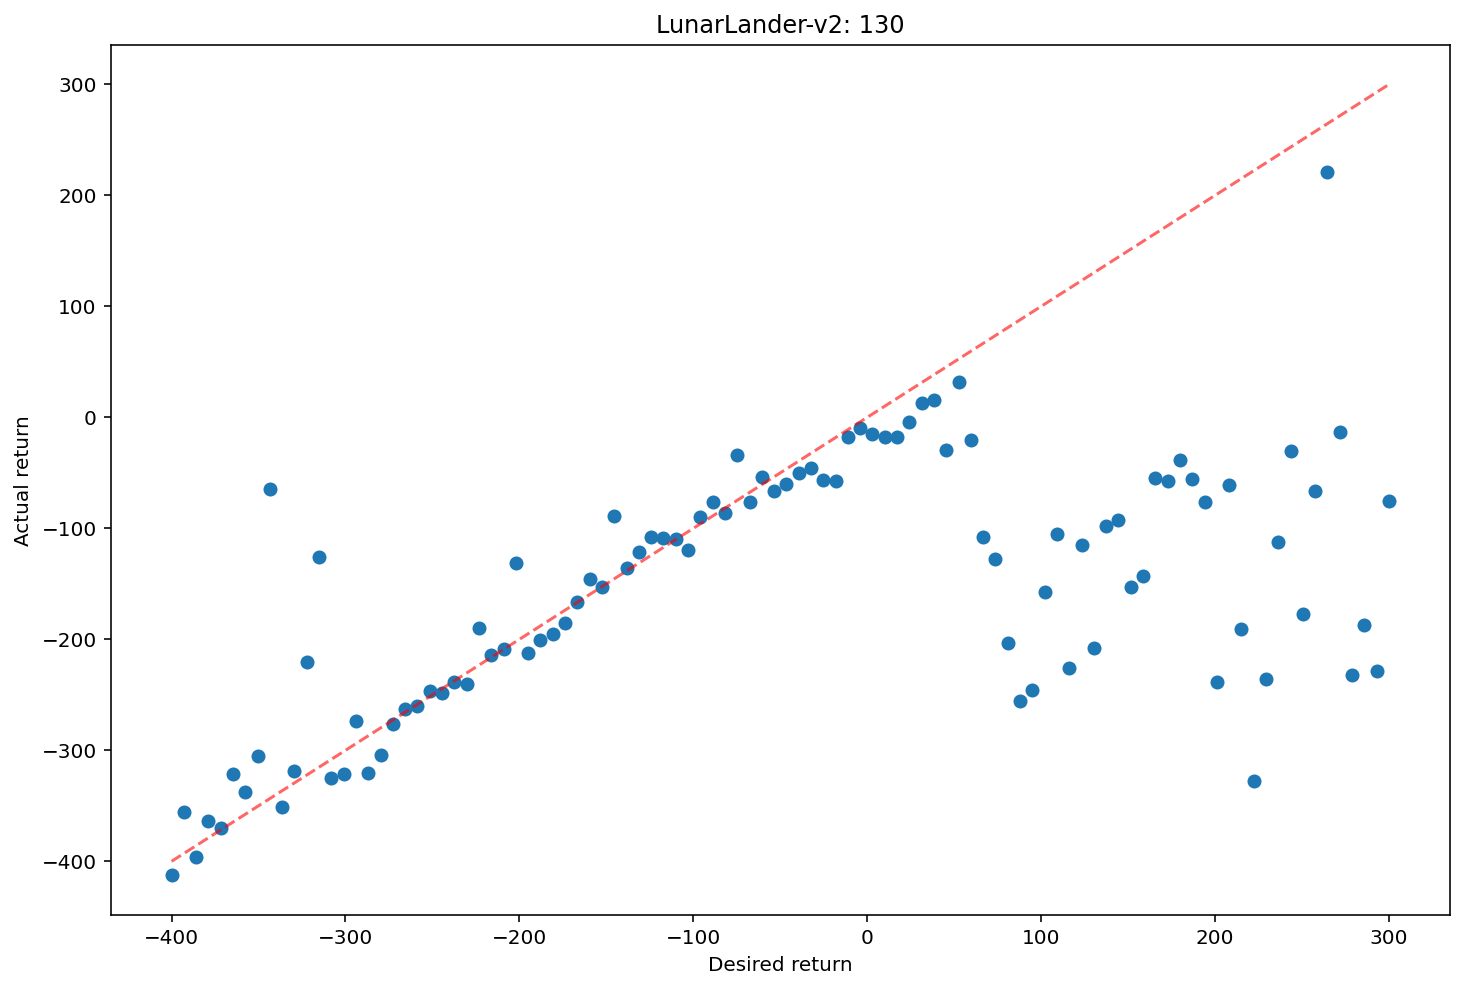

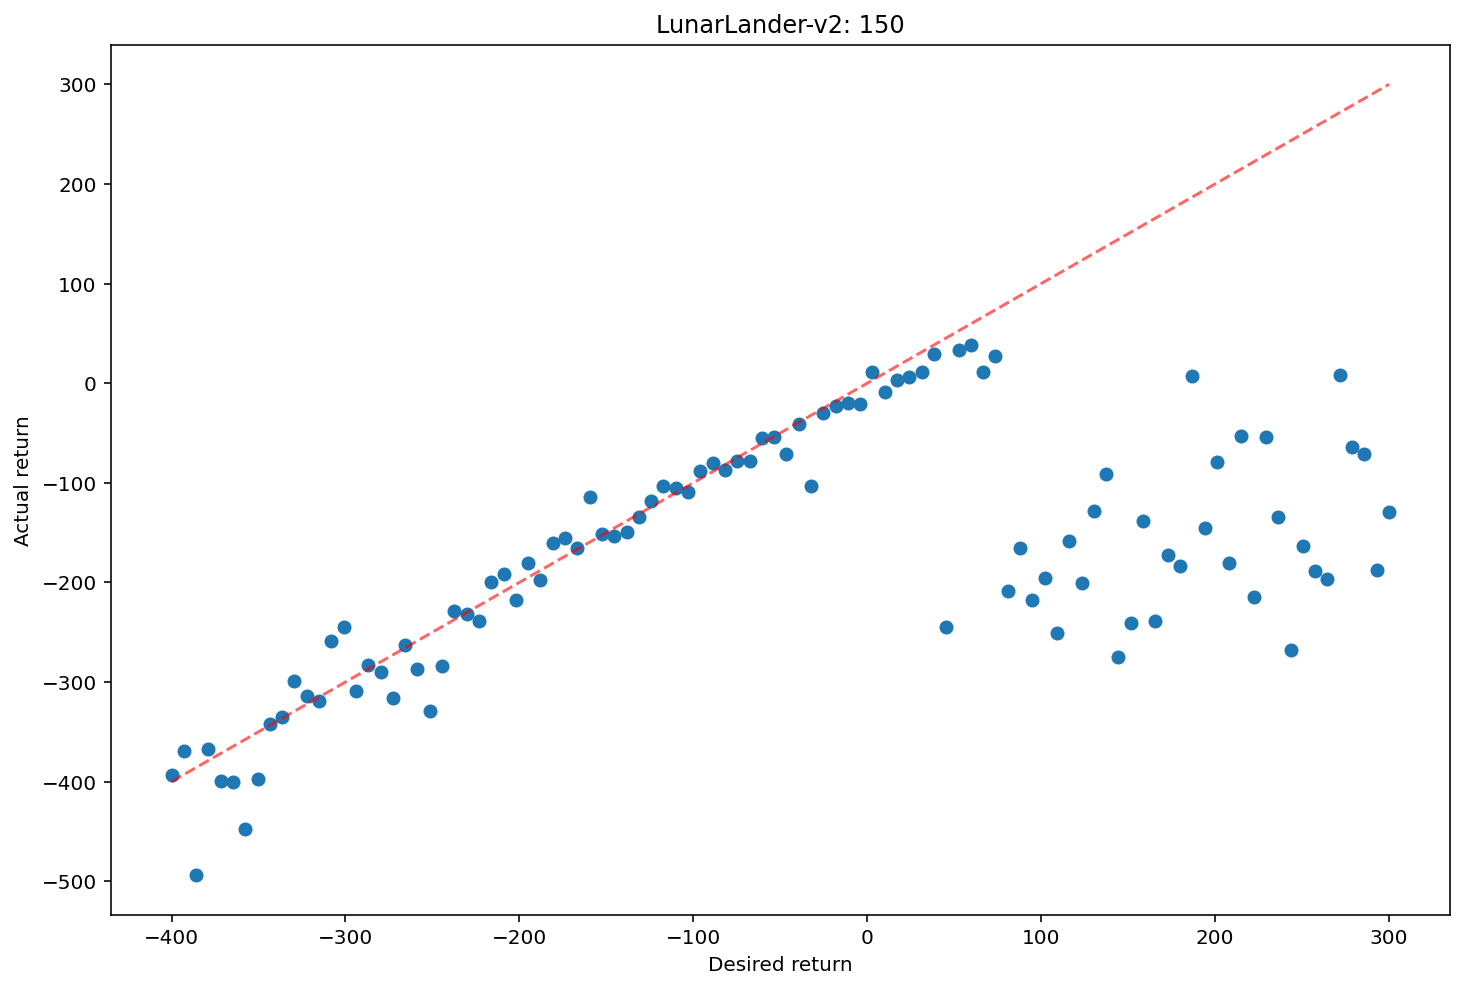

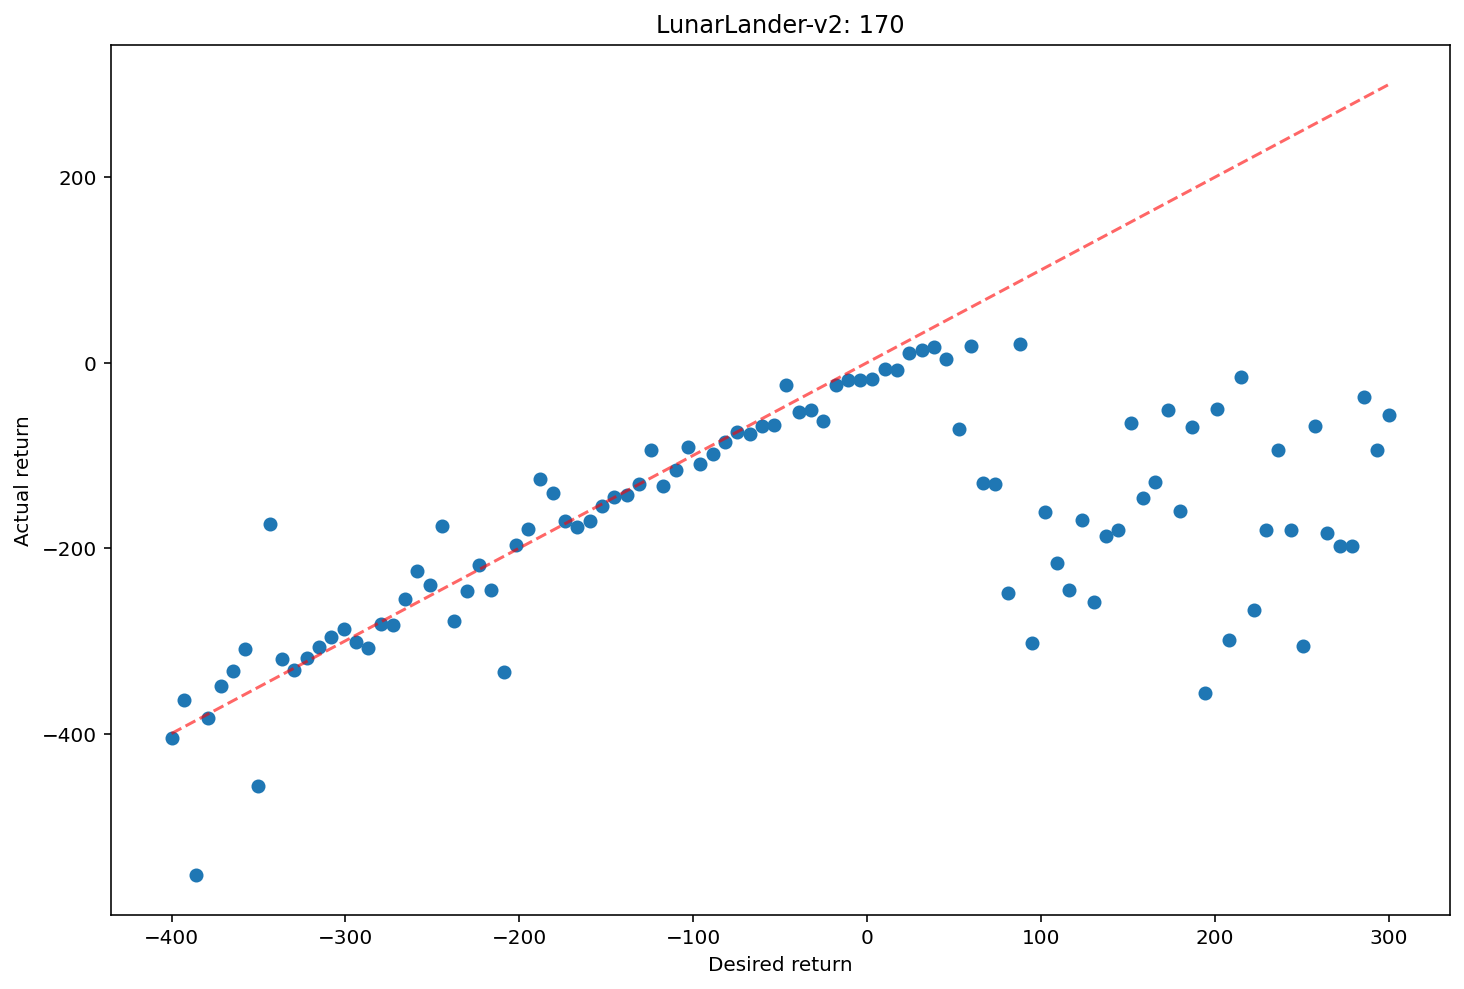

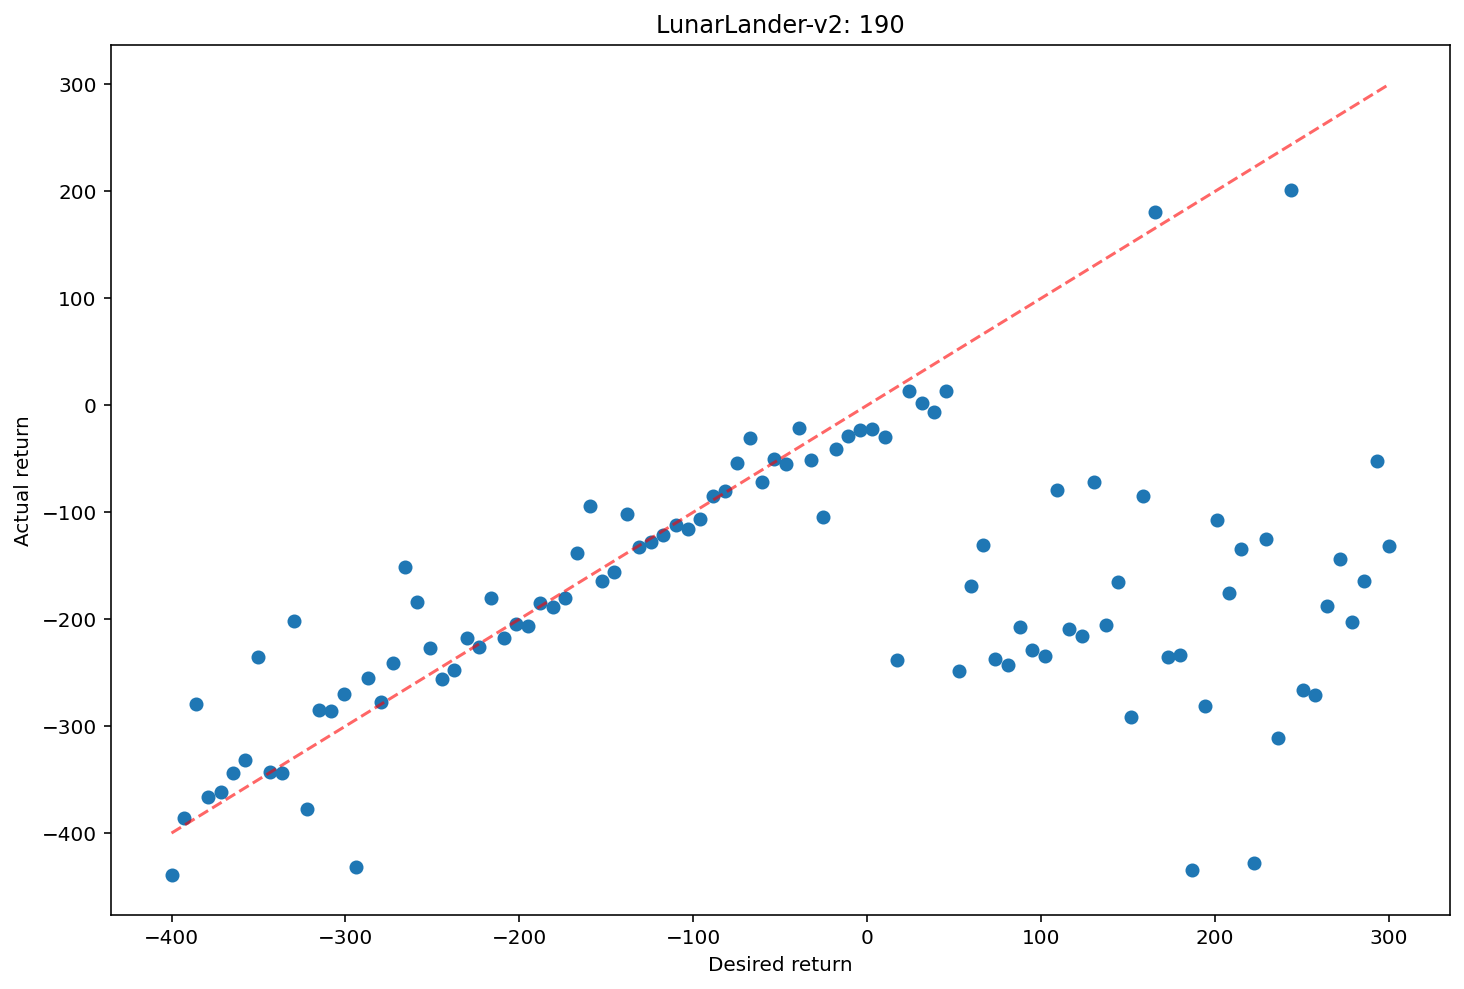

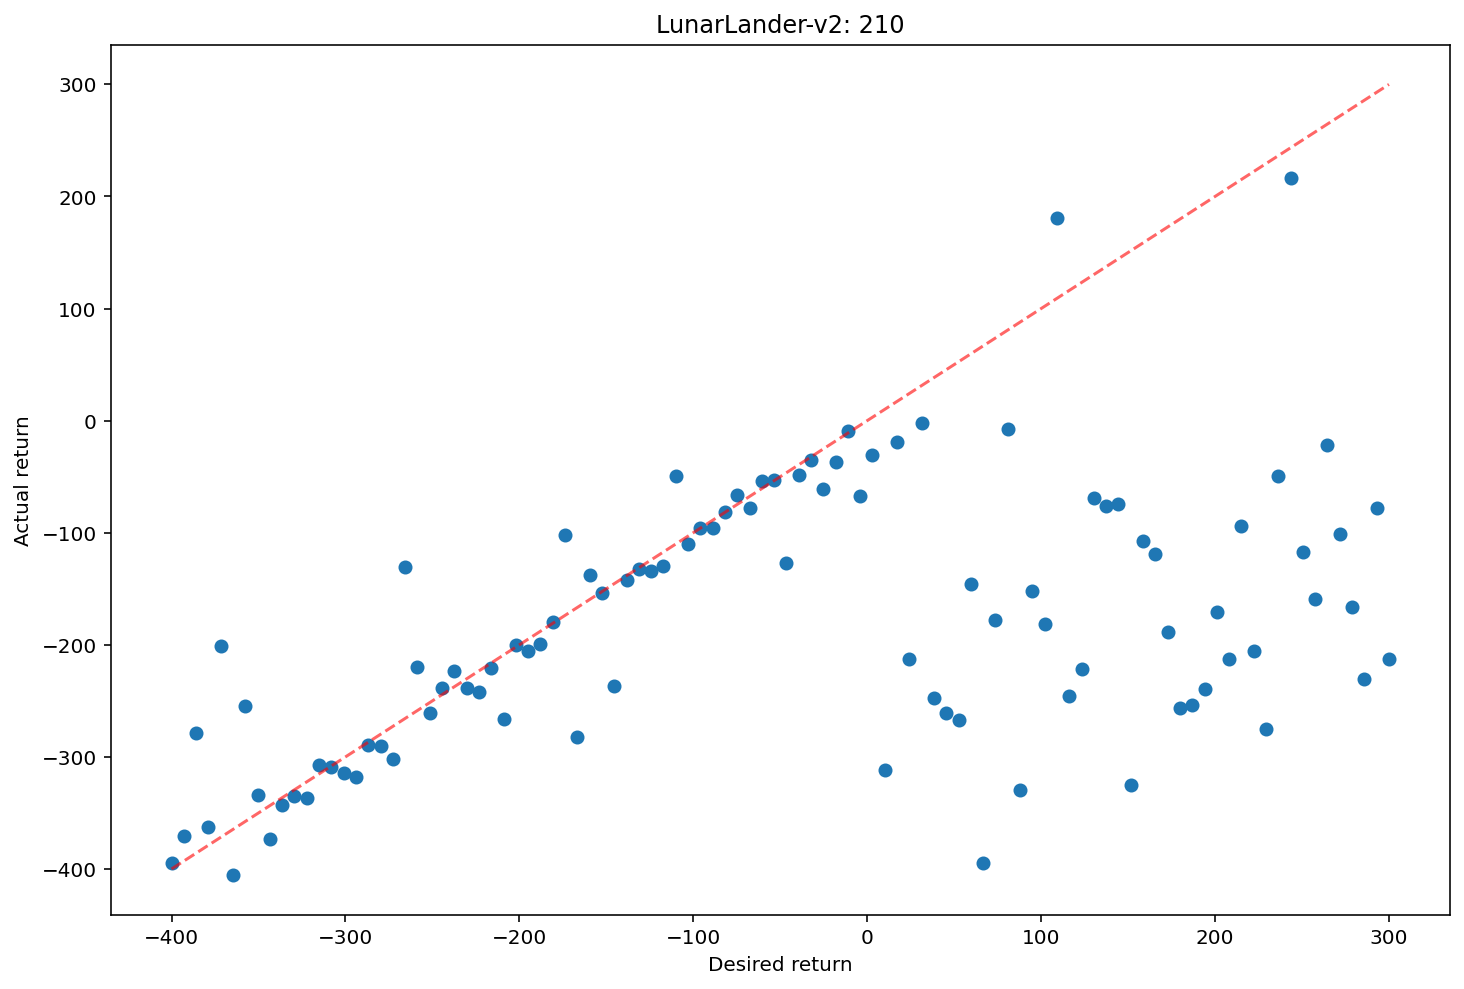

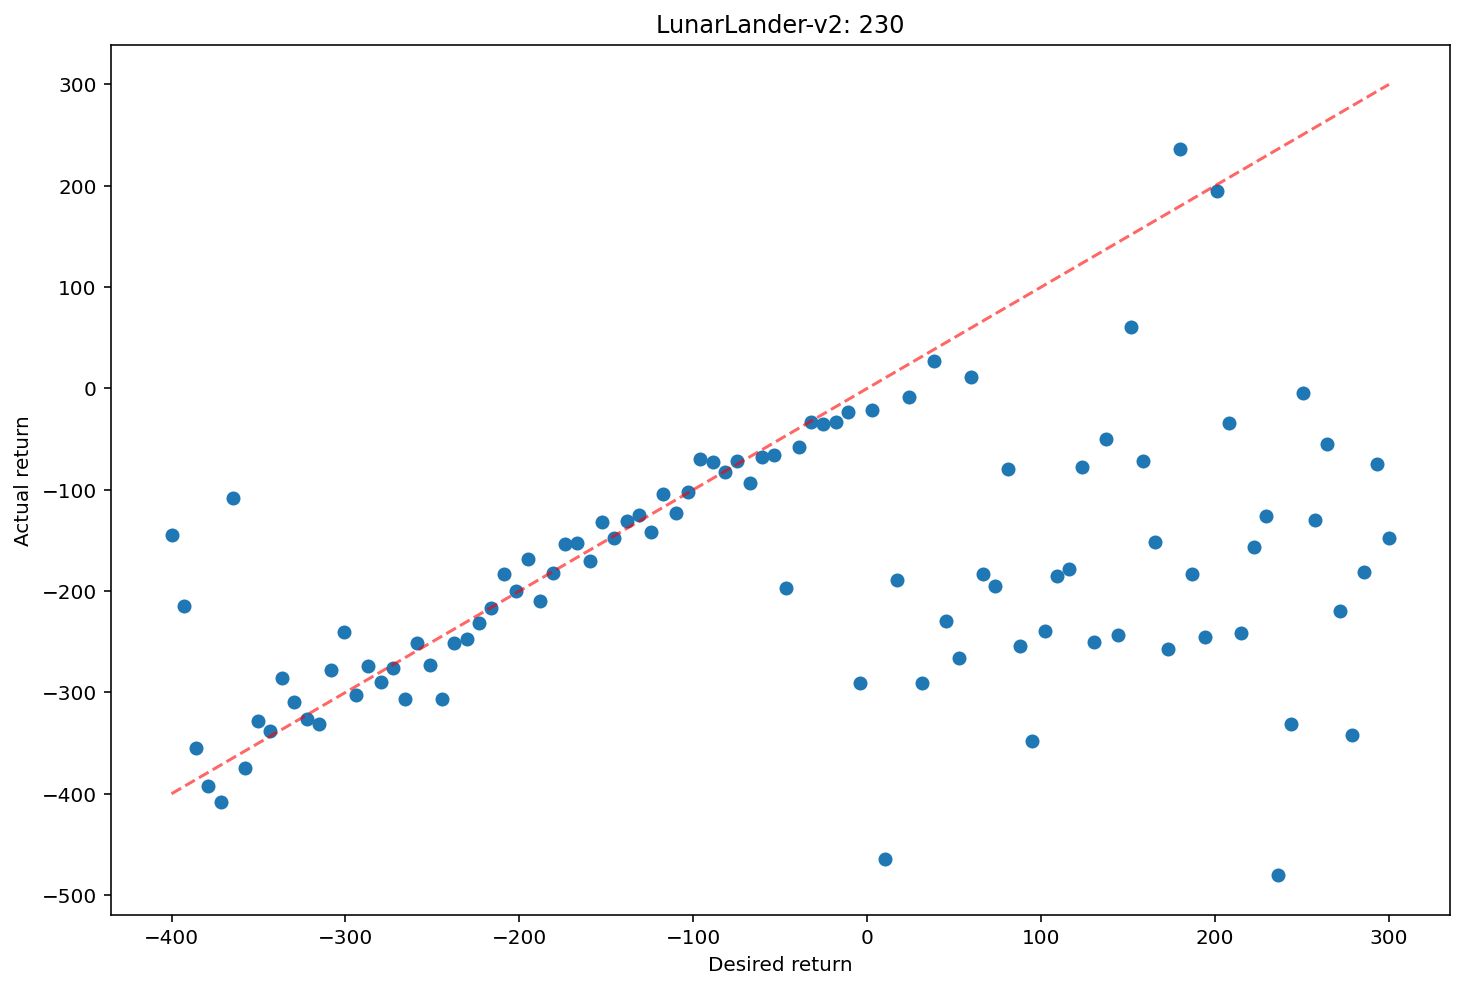

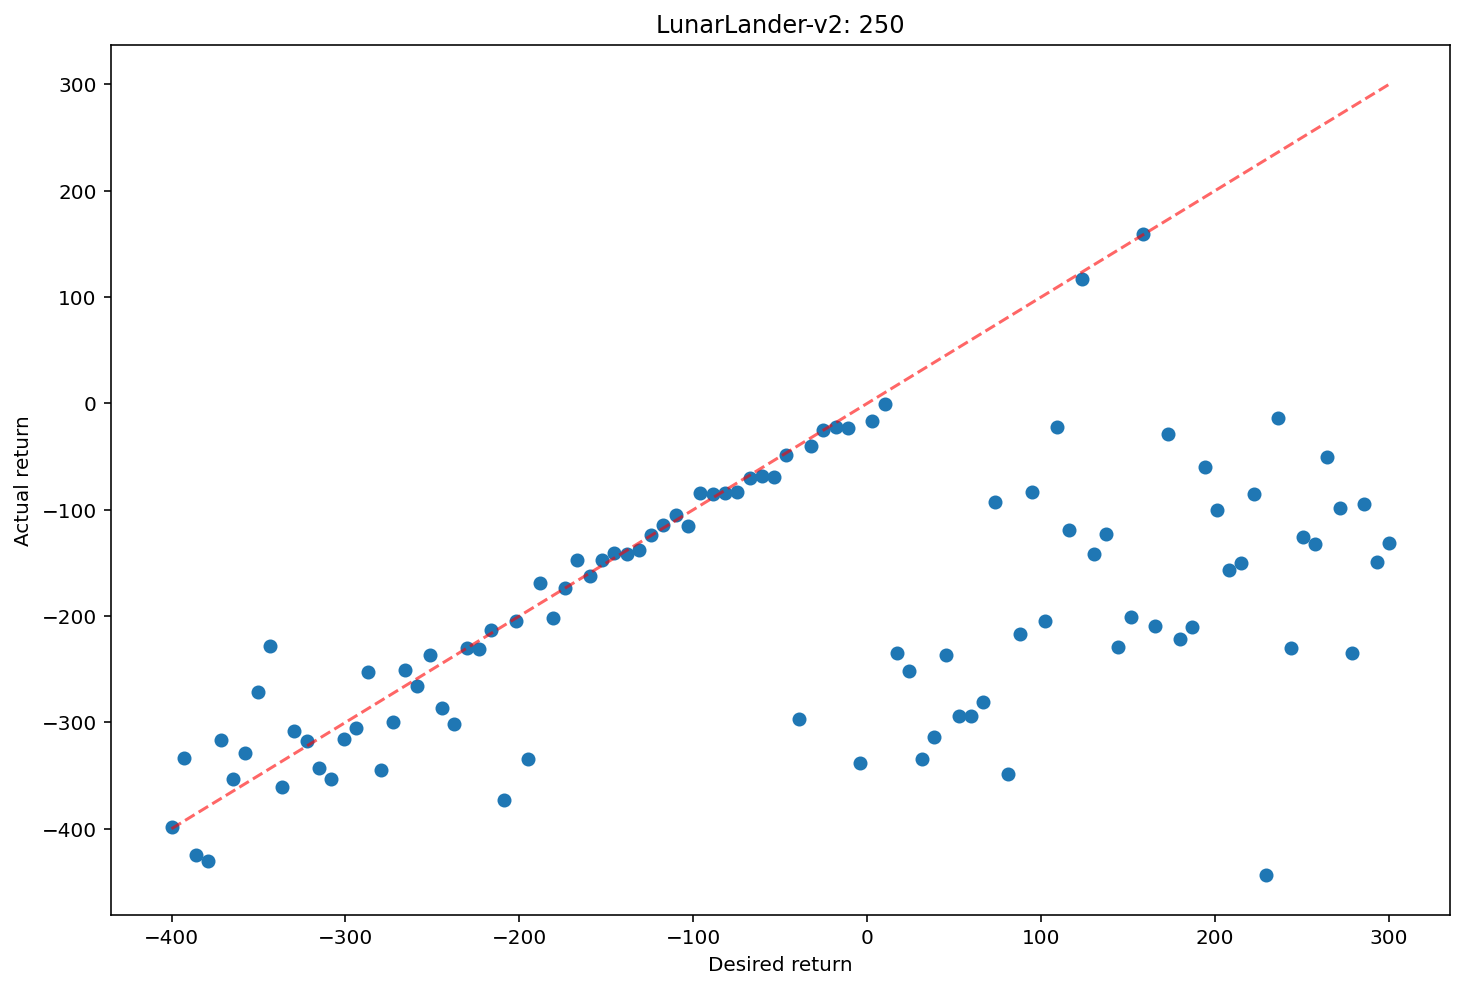

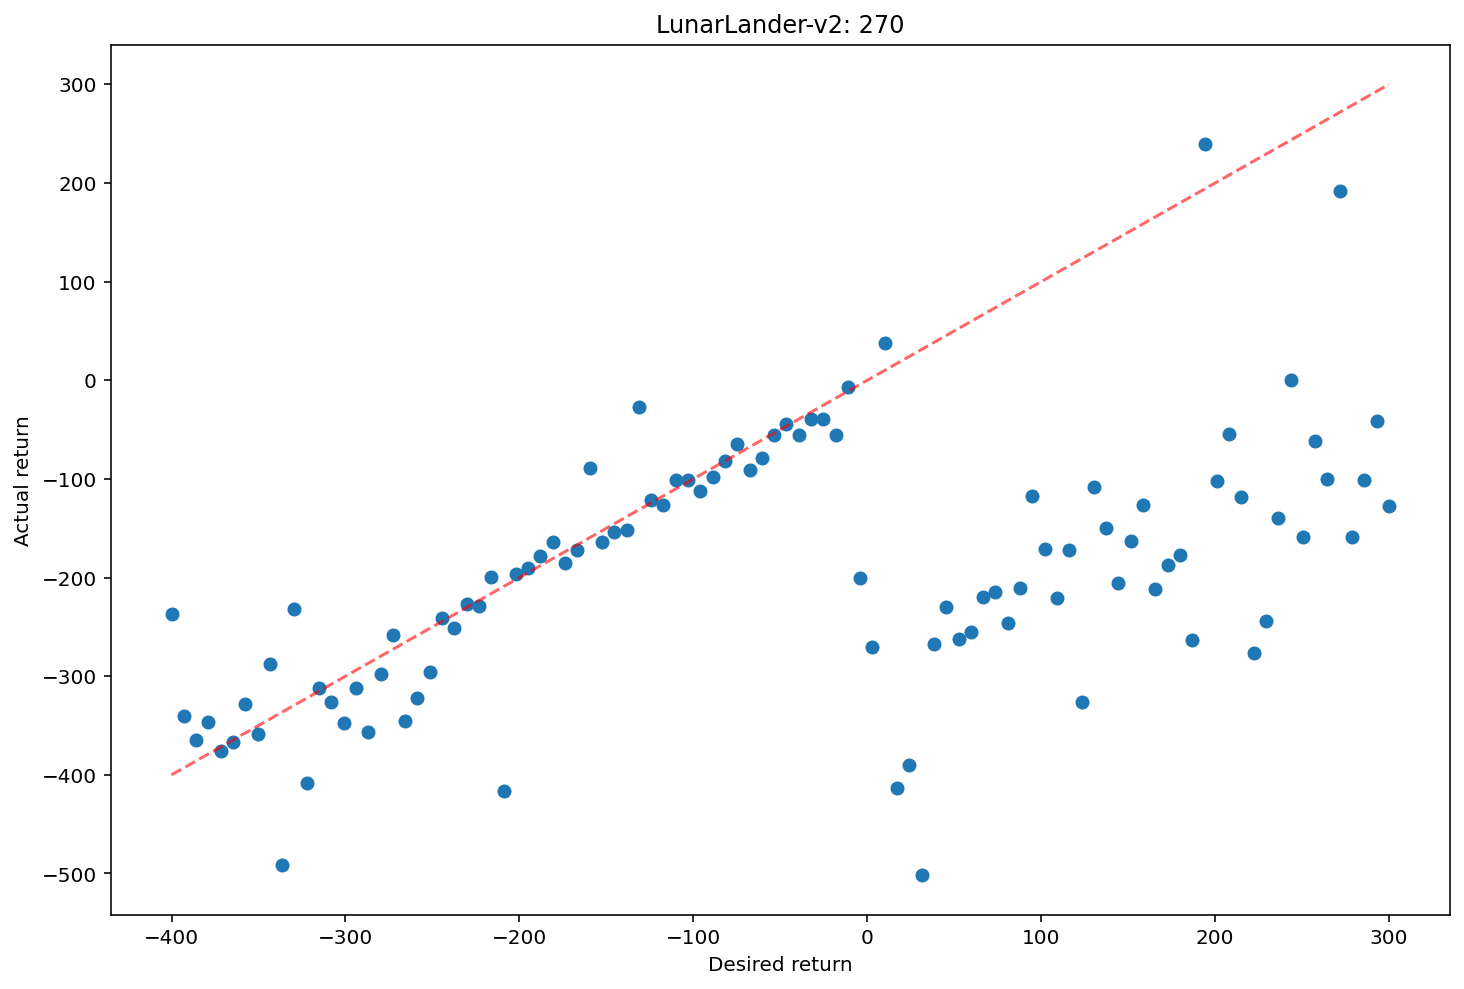

In [5]:
for desired_horizon in np.arange(50, 280, 20):
    desired_returns = np.linspace(-400, 300, 100)

    actual_returns = [rollout(env, agent, dr, desired_horizon)[0] for dr in desired_returns]

    plt.figure(figsize=(12, 8))
    plt.scatter(desired_returns, actual_returns);
    plt.plot(desired_returns, desired_returns, "--", color="red", alpha=0.6)
    plt.xlabel("Desired return")
    plt.ylabel("Actual return")
    plt.title(f"LunarLander-v2: {desired_horizon}");

# Horizons

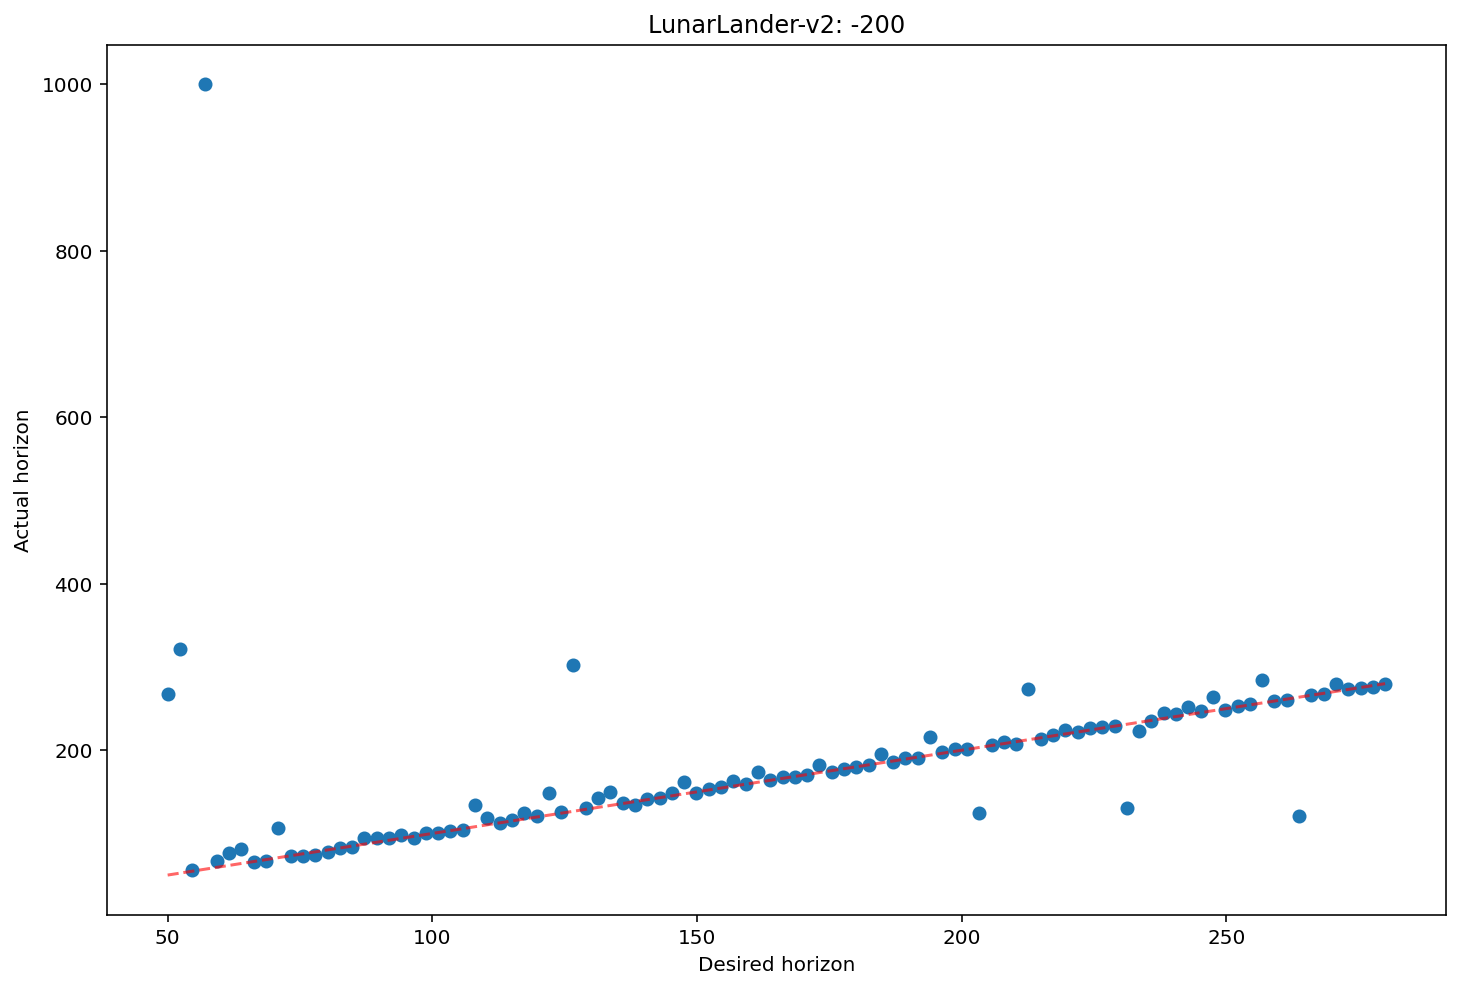

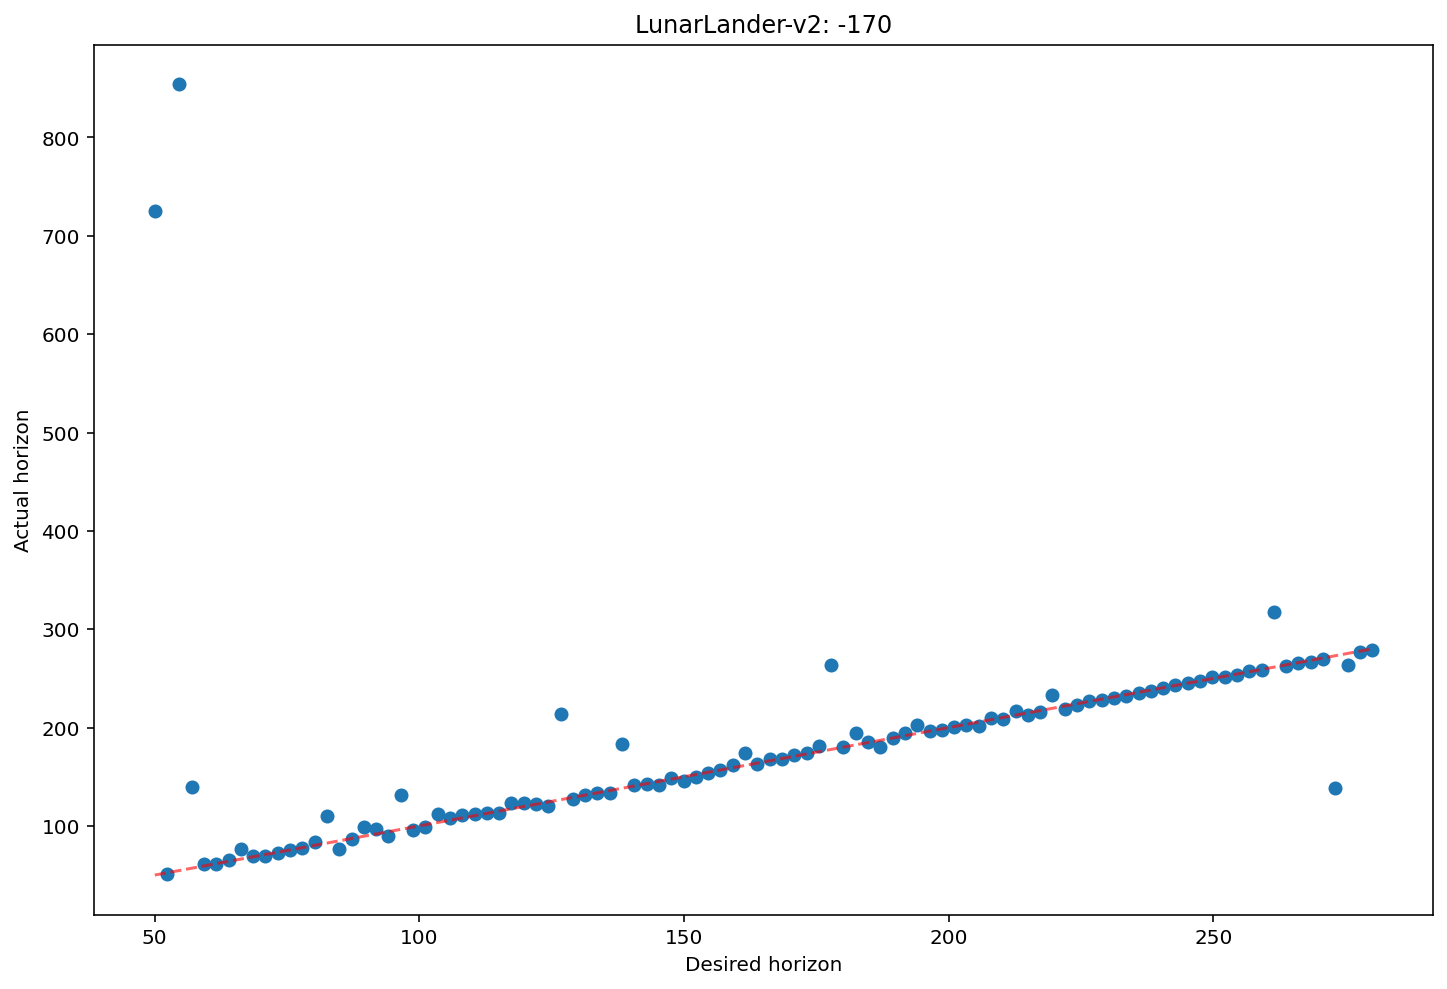

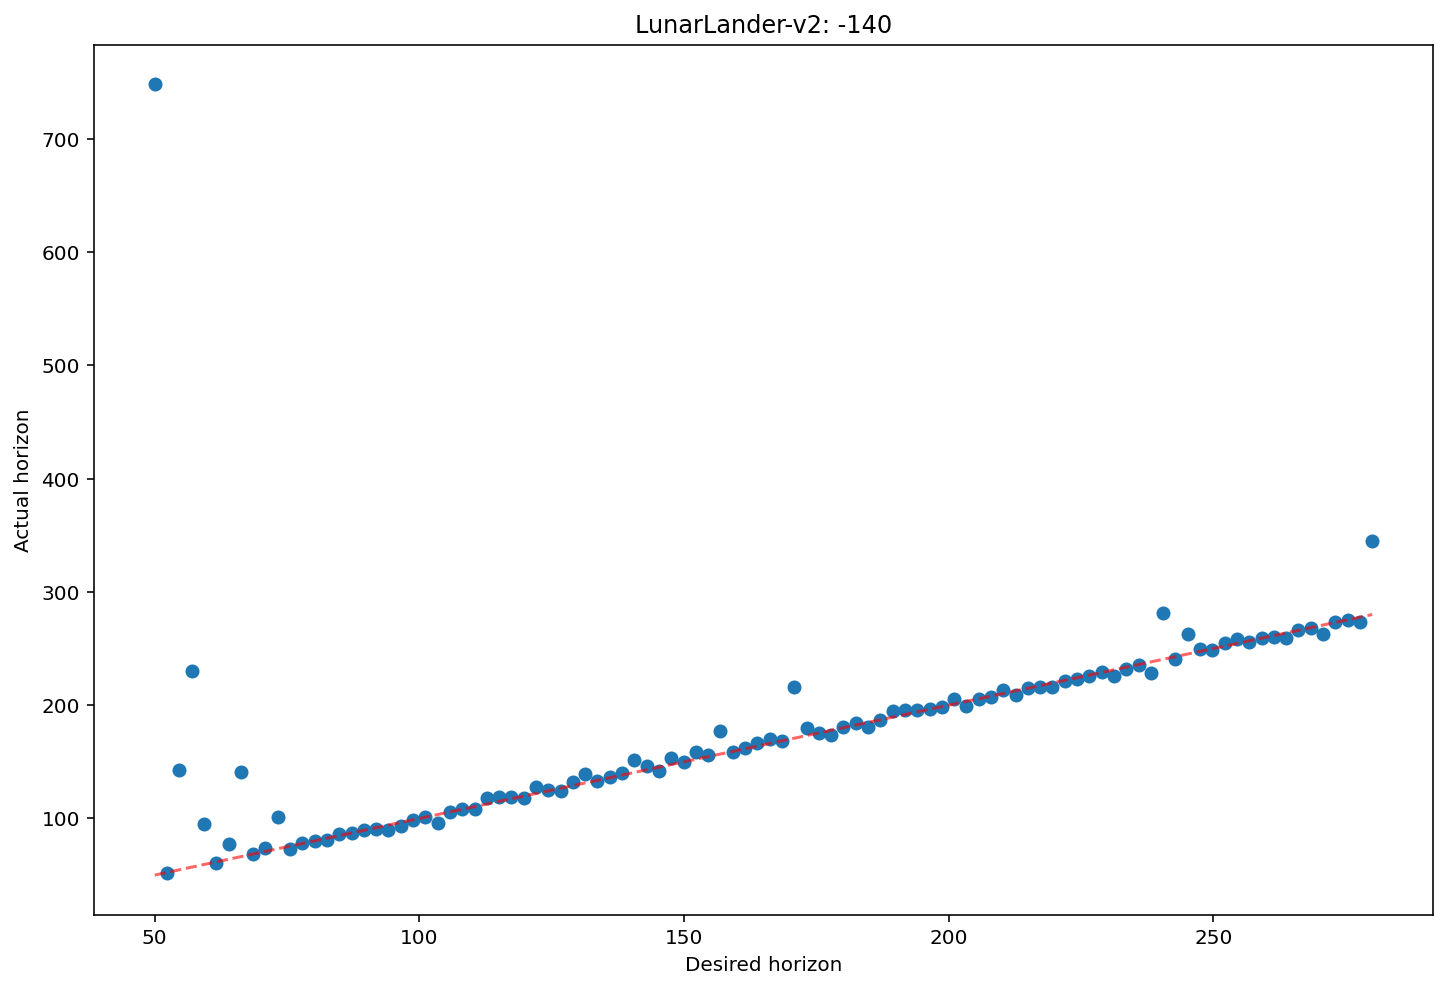

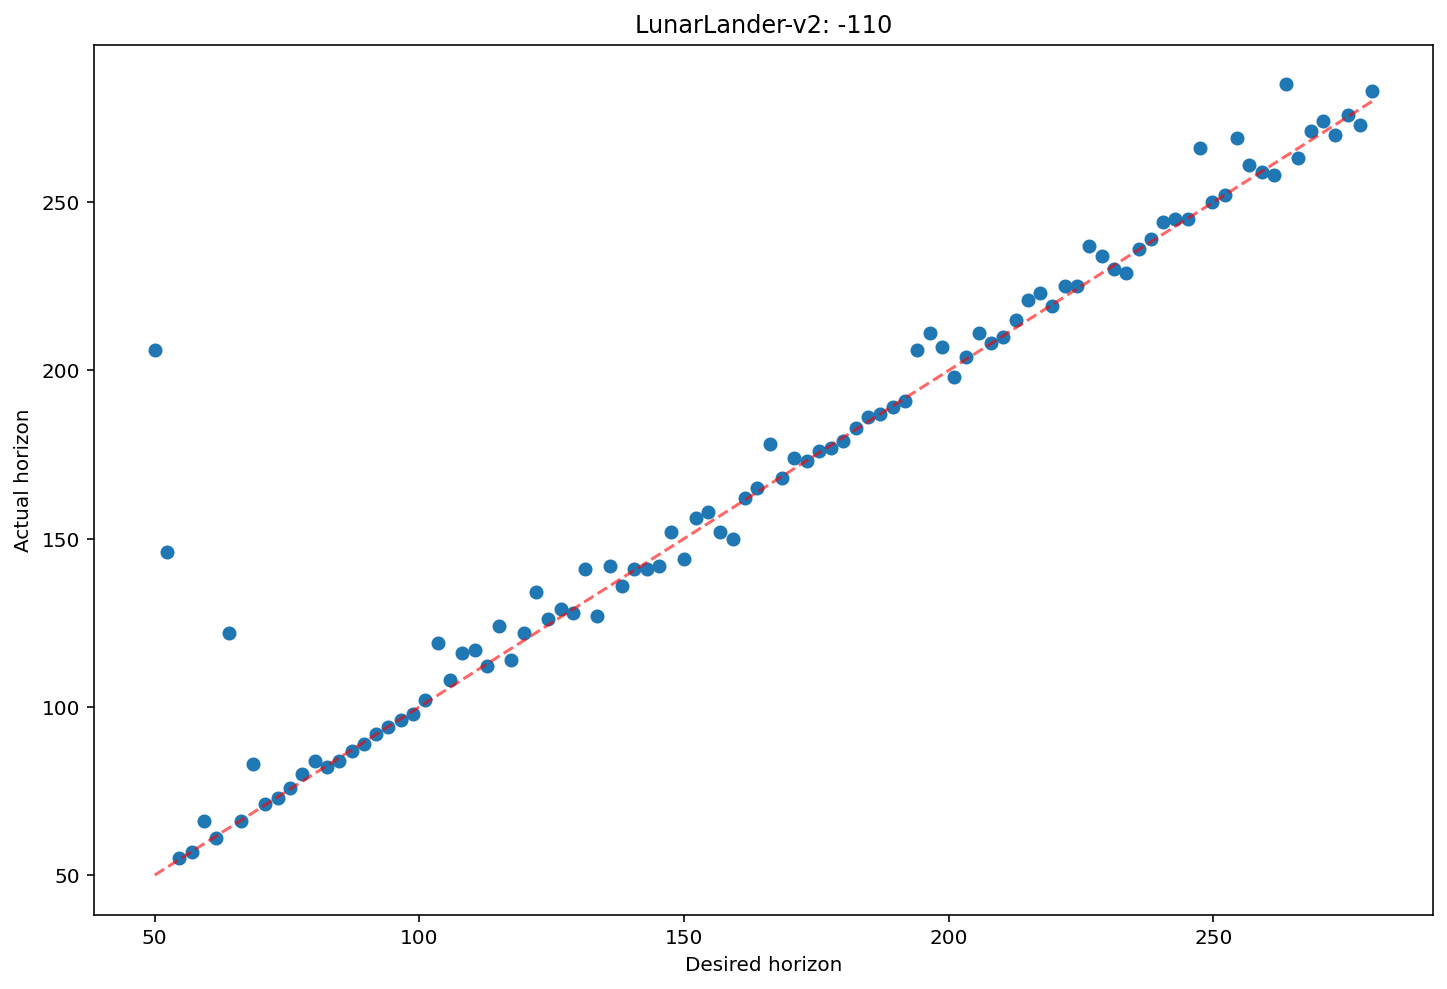

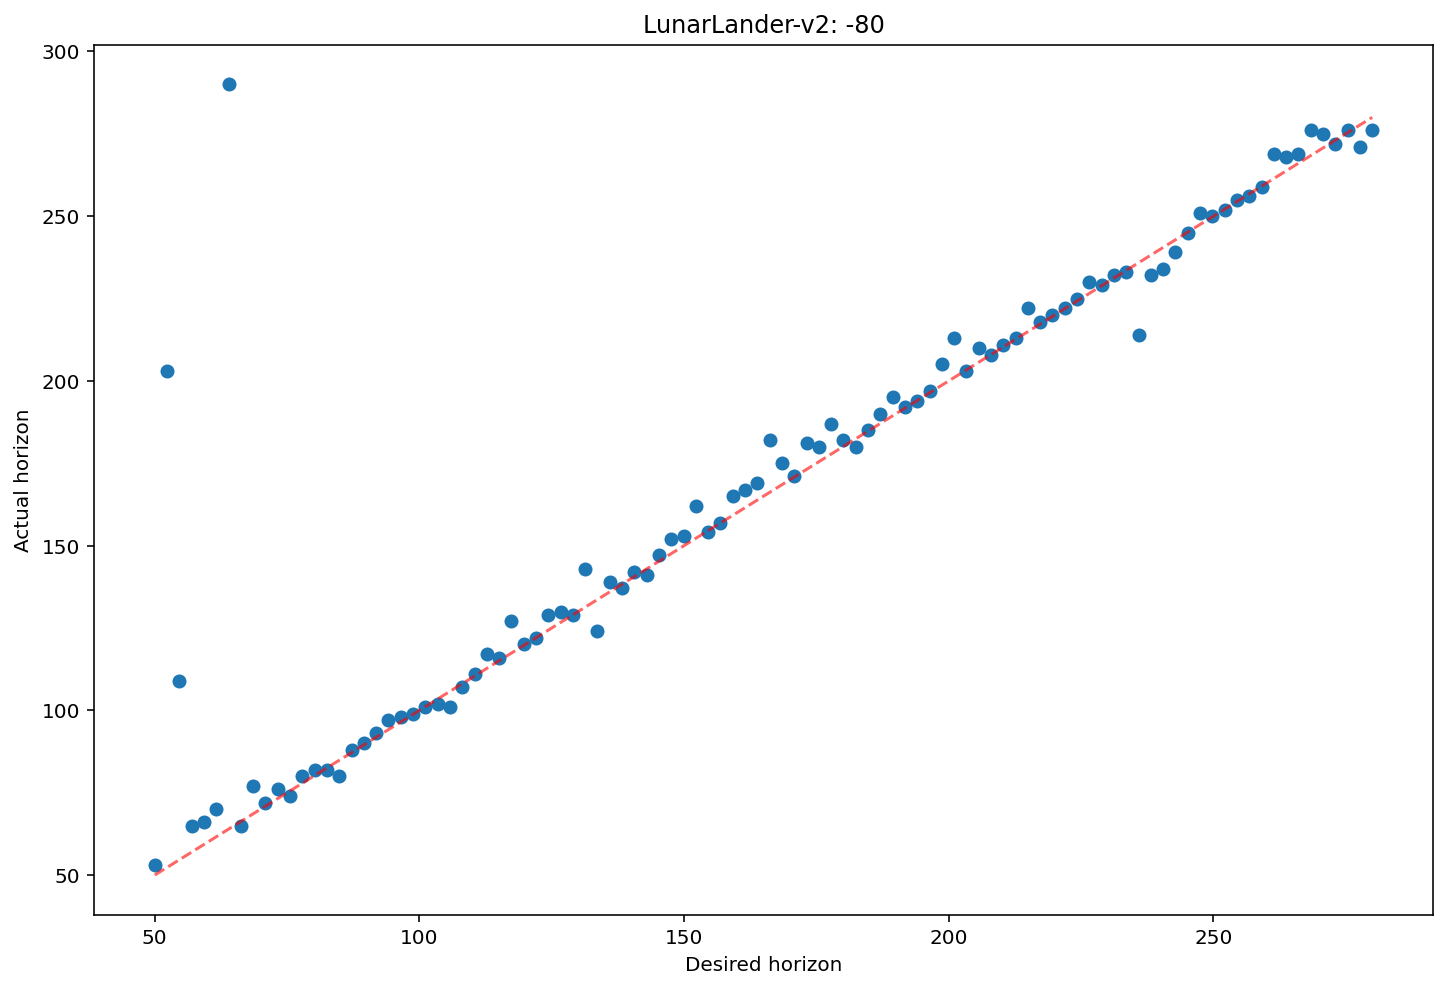

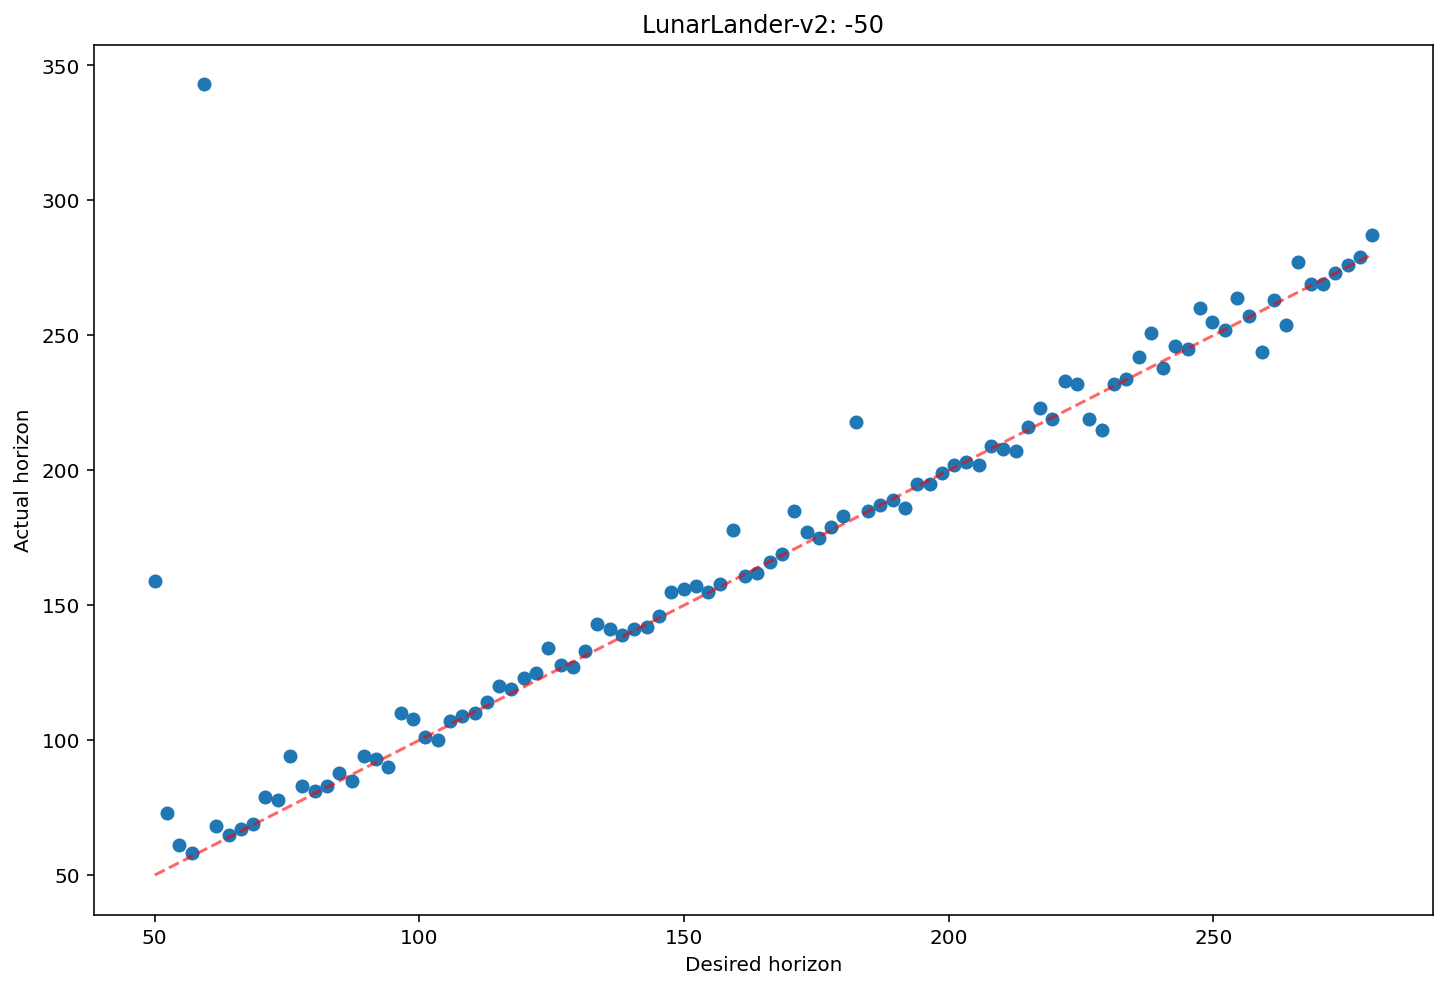

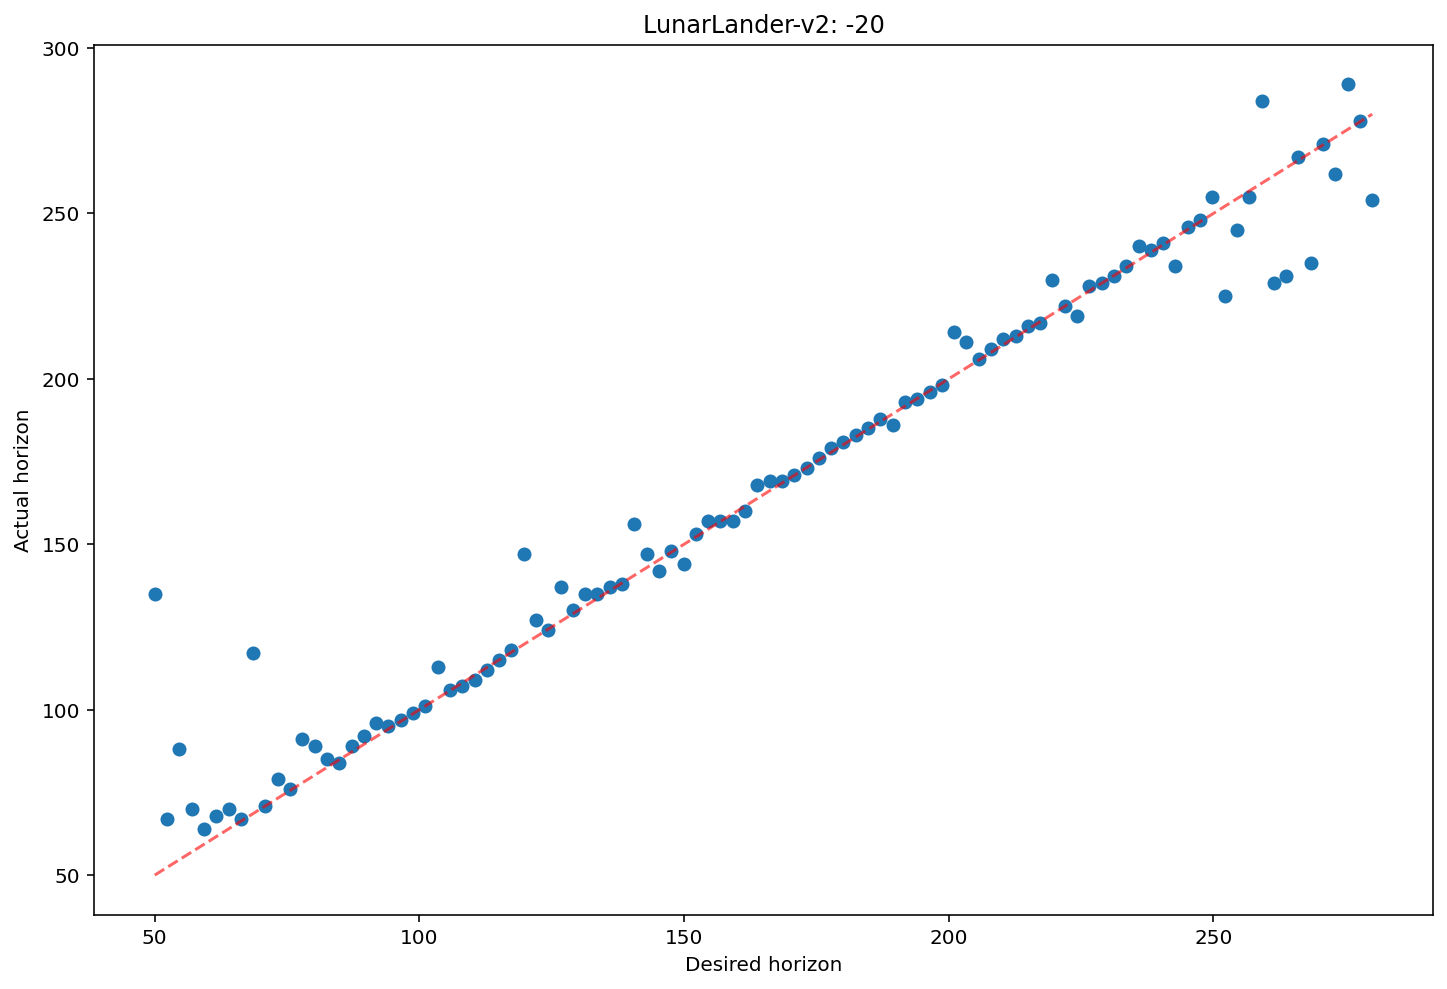

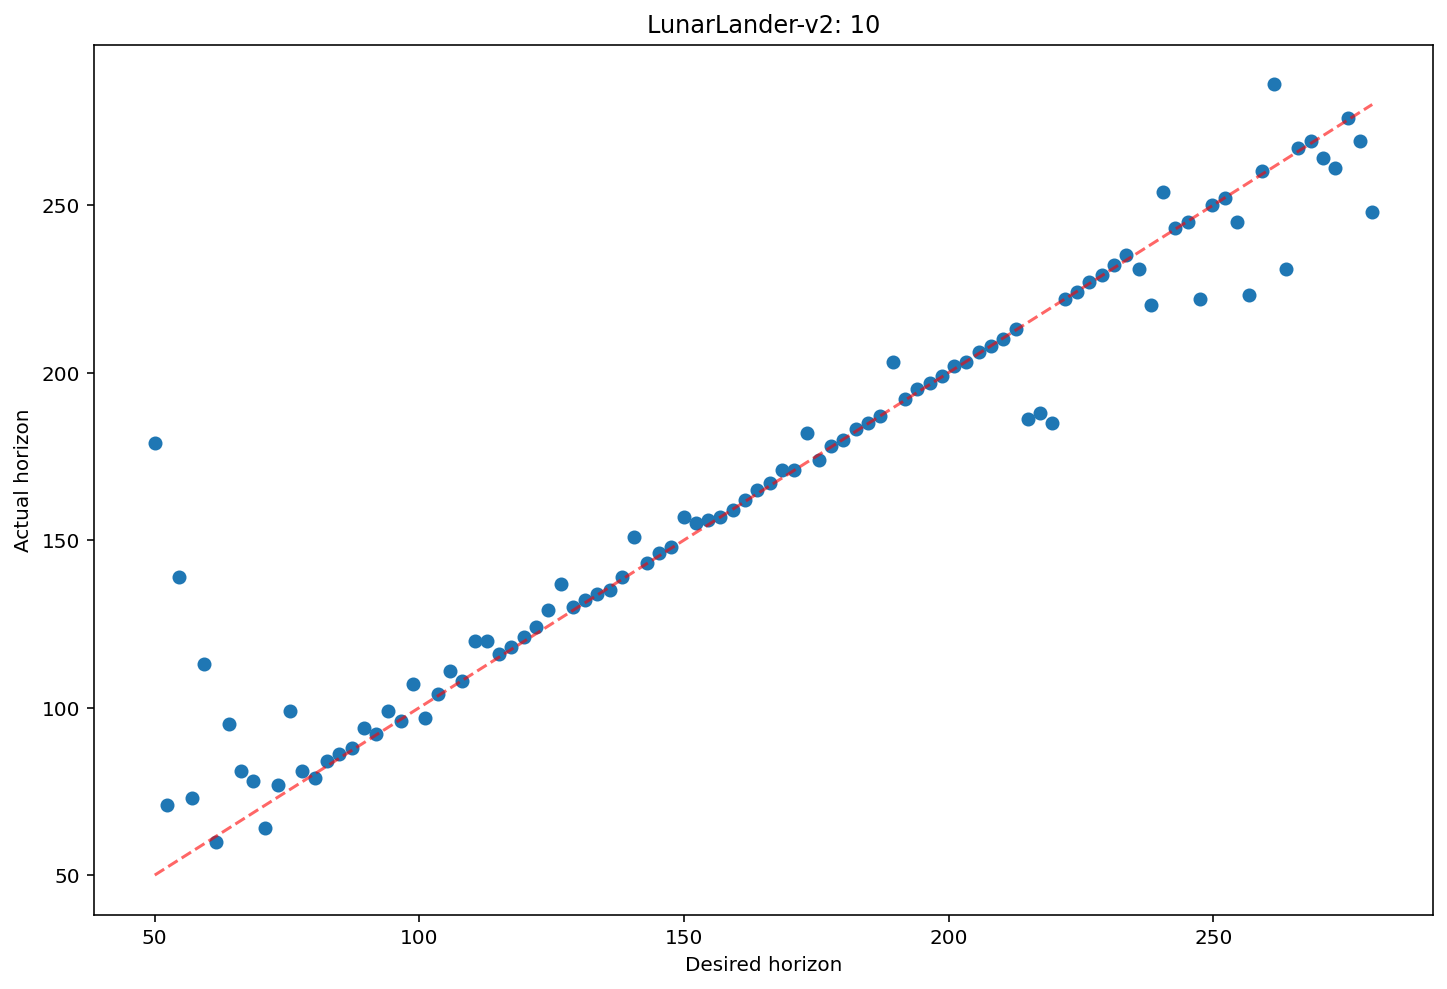

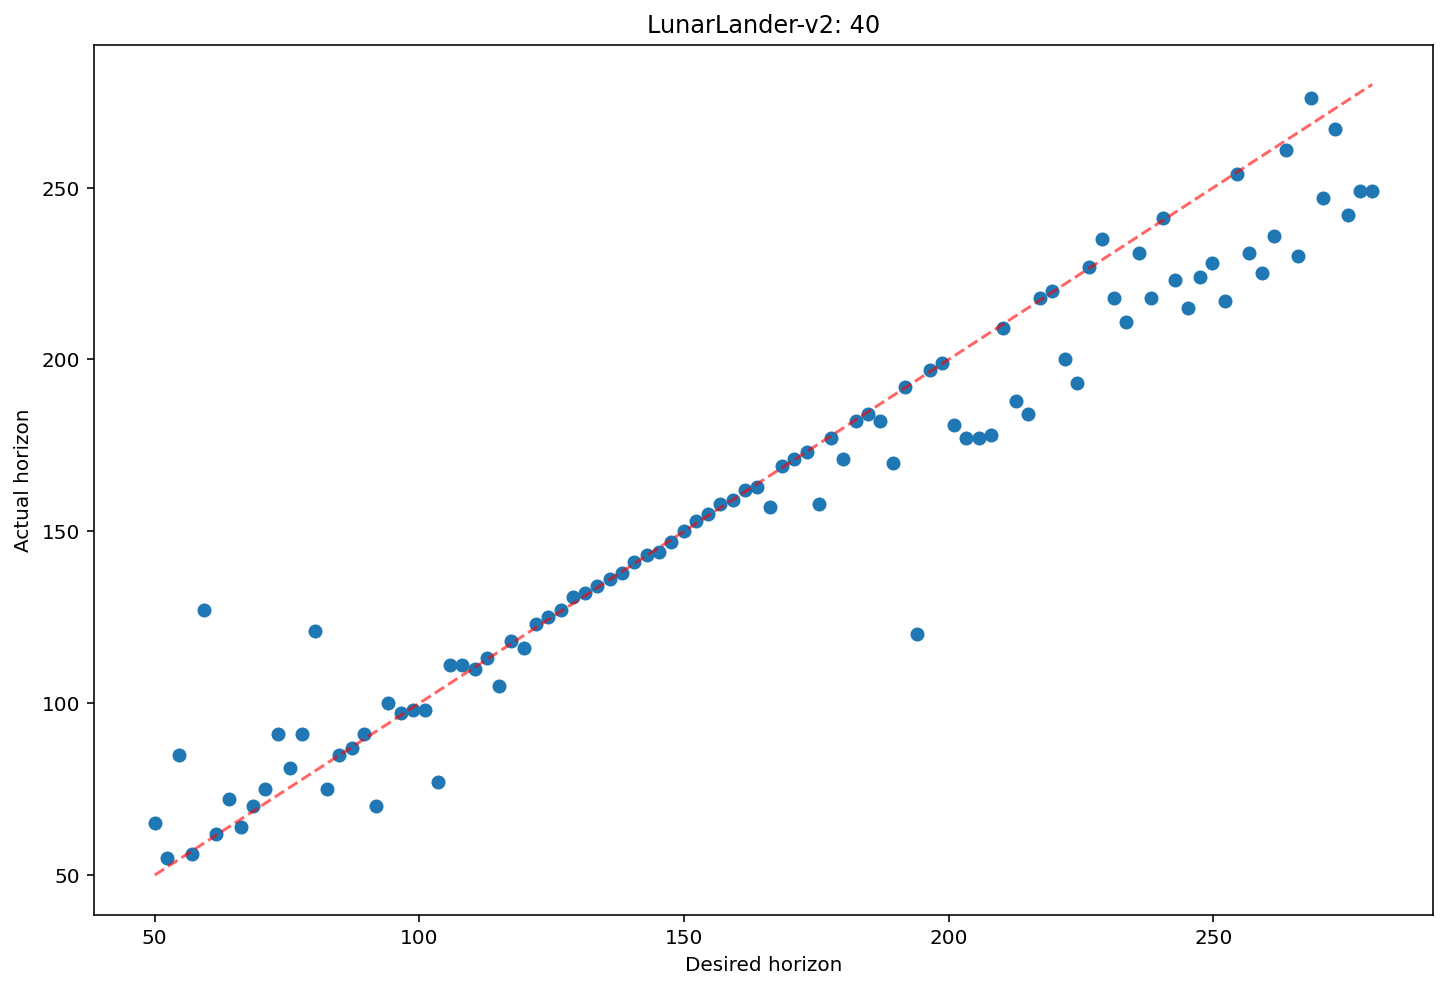

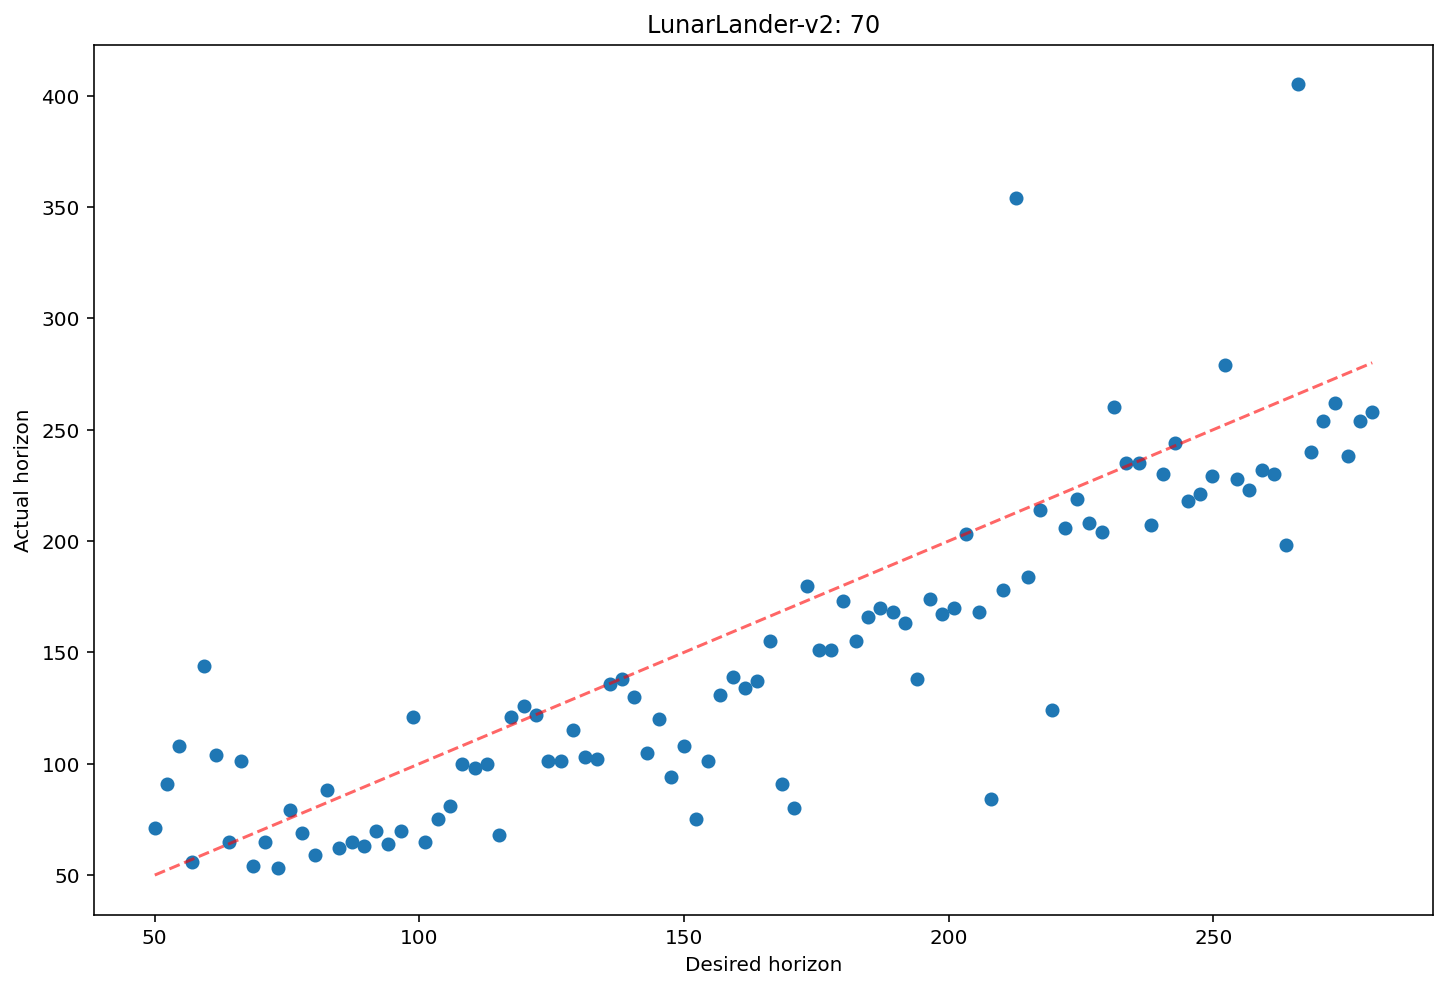

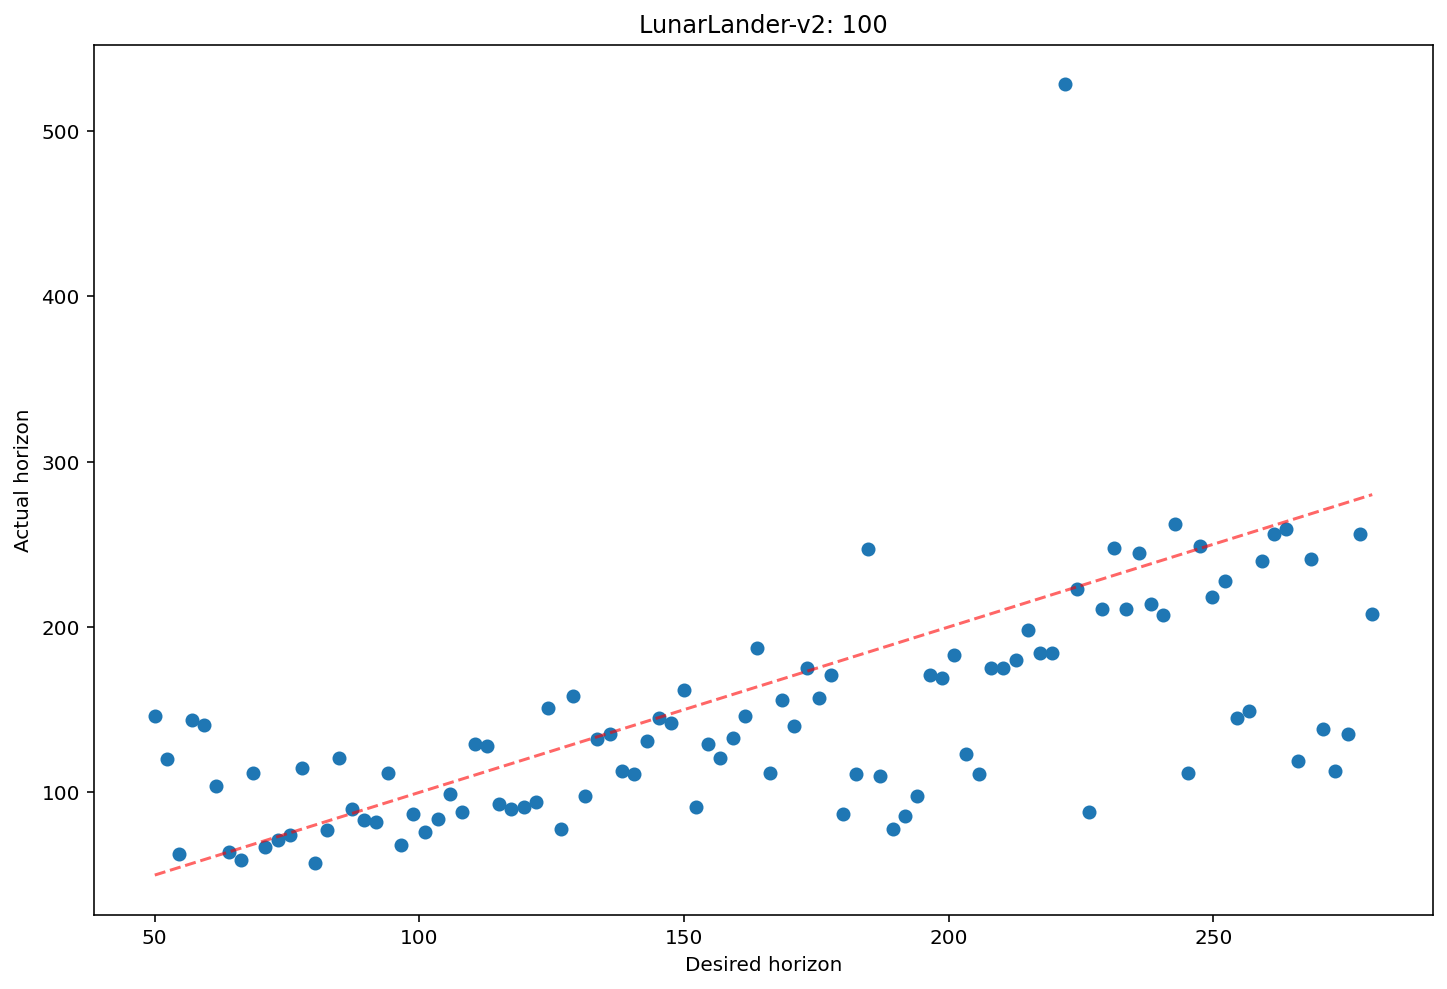

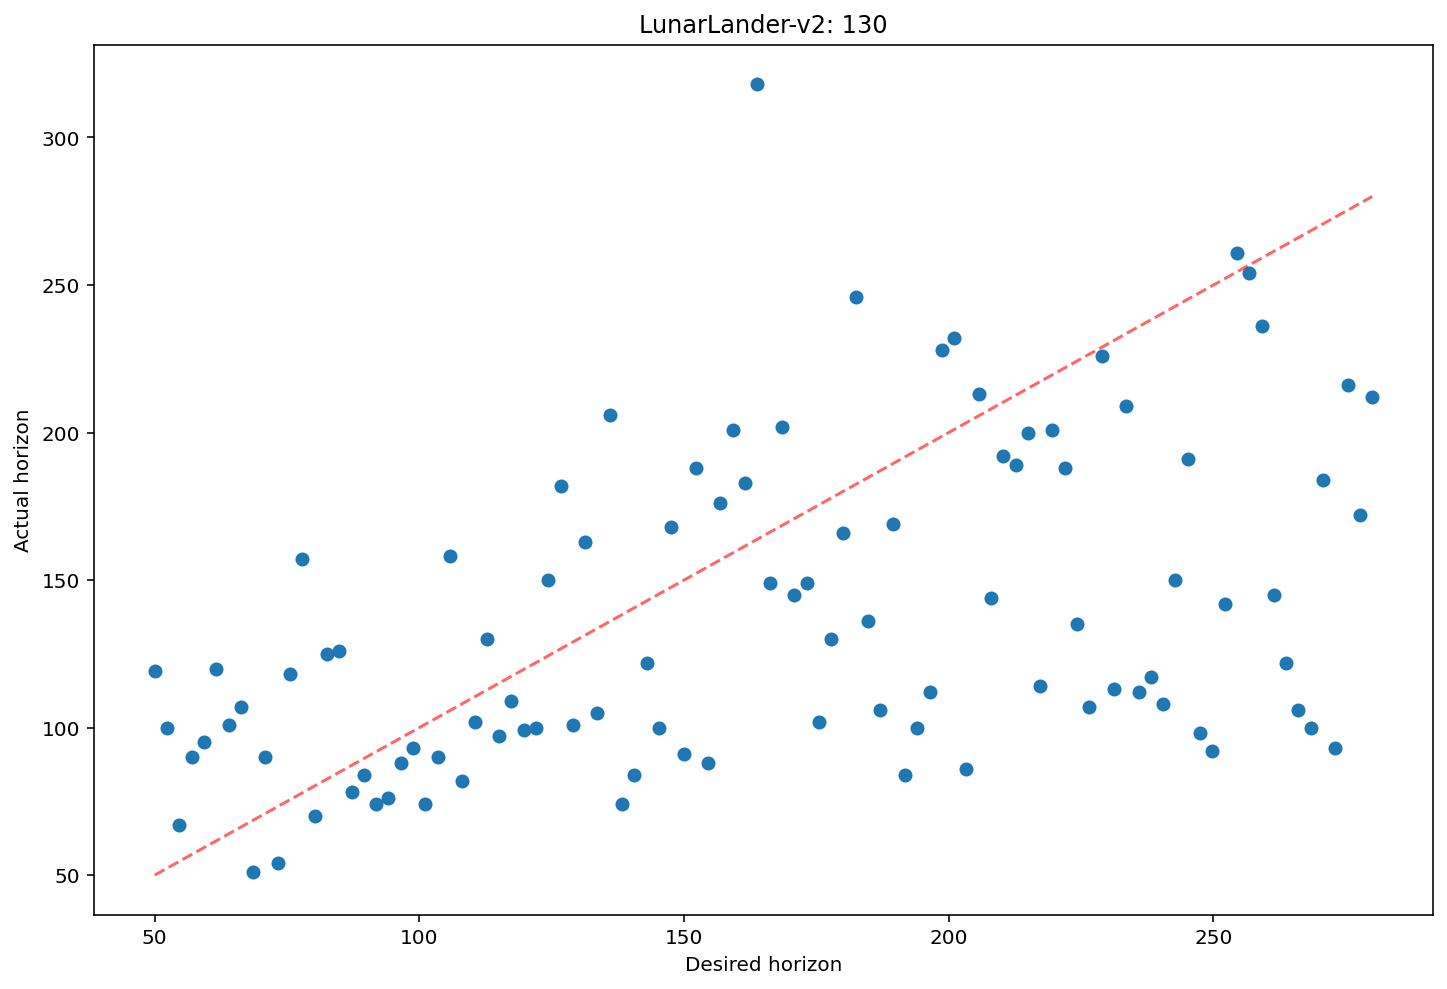

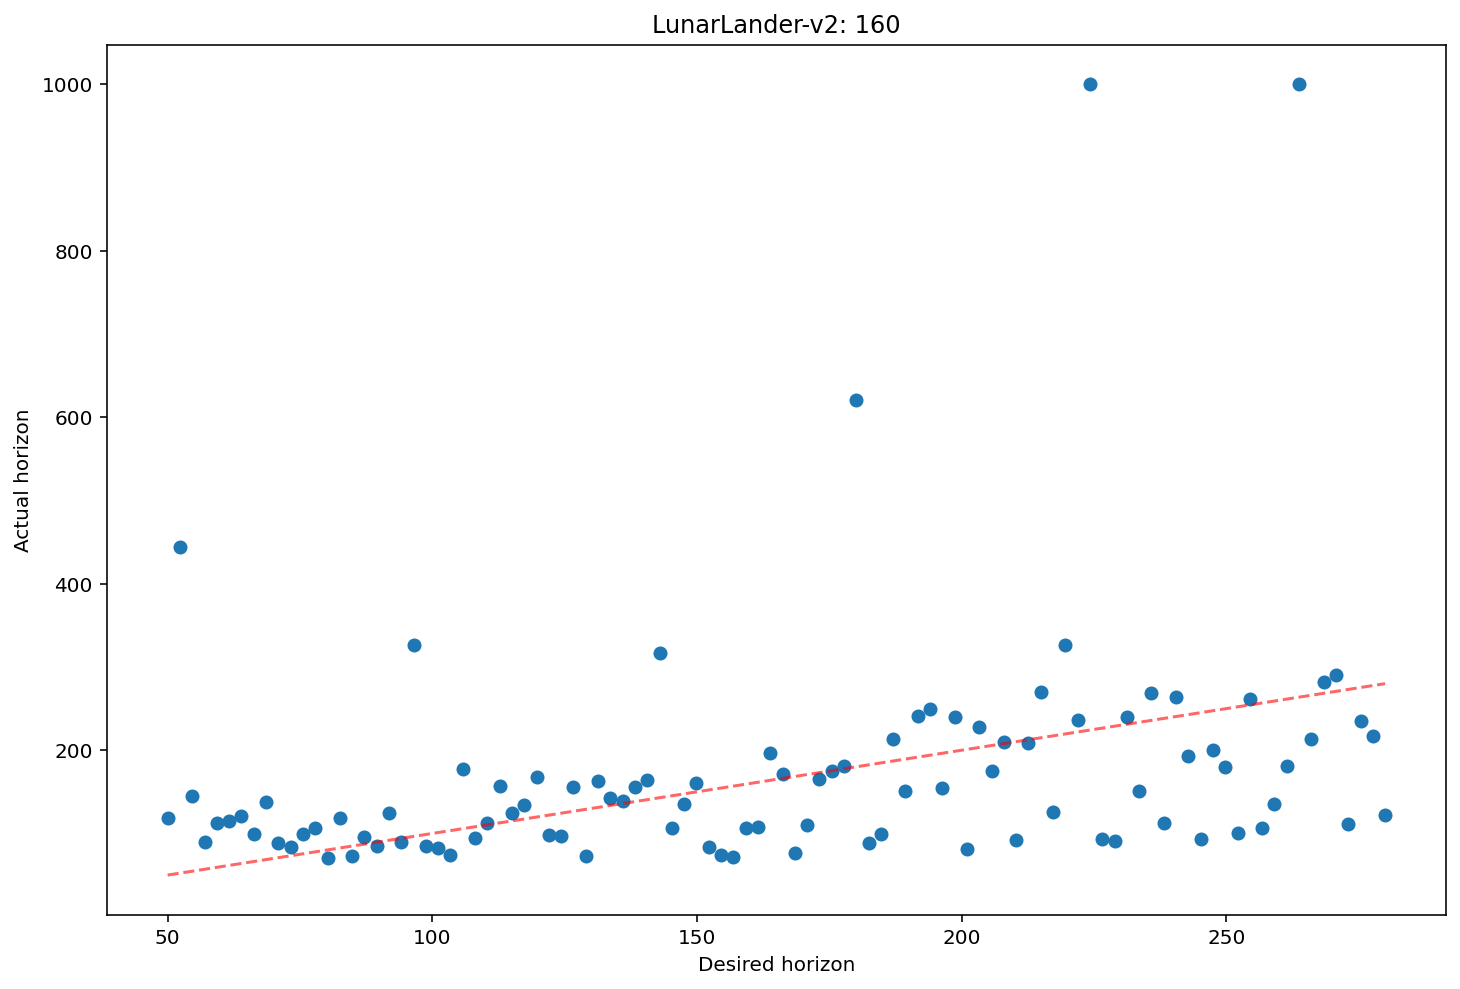

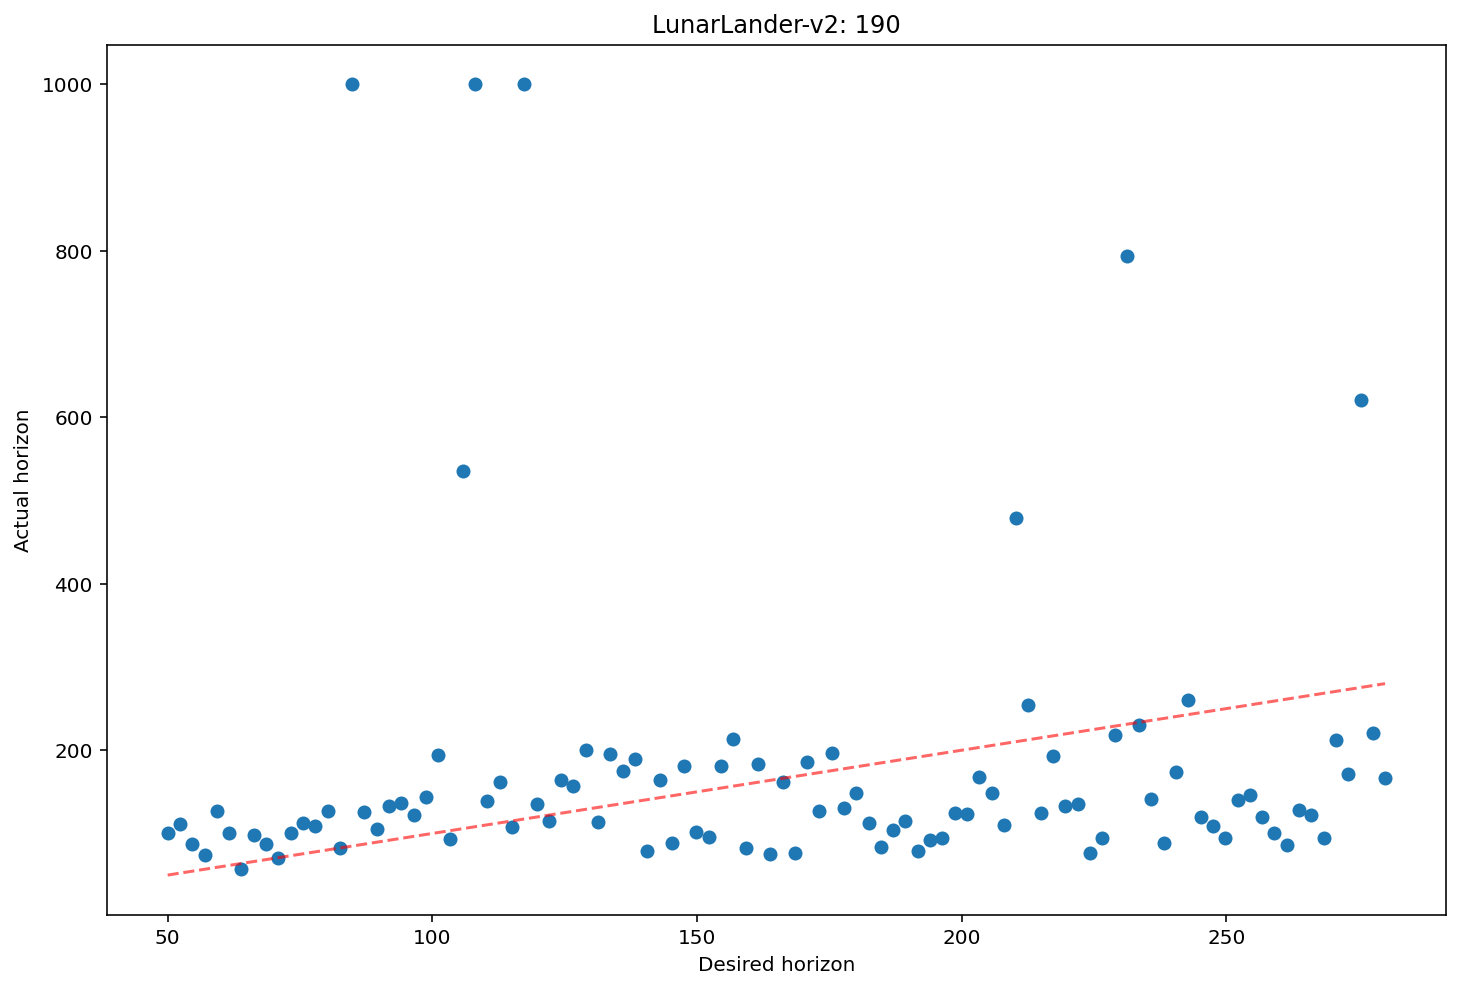

In [6]:
for desired_reward in np.arange(-200, 200, 30):
    desired_horizons = np.linspace(50, 280, 100)

    actual_horizons = [rollout(env, agent, desired_reward, dh)[1] for dh in desired_horizons]

    plt.figure(figsize=(12, 8))
    plt.scatter(desired_horizons, actual_horizons);
    plt.plot(desired_horizons, desired_horizons, "--", color="red", alpha=0.6)
    plt.xlabel("Desired horizon")
    plt.ylabel("Actual horizon")
    plt.title(f"LunarLander-v2: {desired_reward}");